In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from glob import glob
from lmfit import minimize, Model
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from specutils.manipulation import LinearInterpolatedResampler
from specutils import Spectrum1D

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [2]:
import seaborn as sns
from matplotlib import cycler
import matplotlib as mpl
clrs = sns.color_palette('Set1')
clrs[5] = (255/255, 200/255, 80/255)
colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rcParams['figure.dpi'] = 75

In [3]:
#Keep units for future math
class spectrum():
    def __init__(self, files, linelist_file):
    
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        self.linelist = pd.read_csv(linelist_file, skiprows=2)
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS']
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date,
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)
    
    def mask_df(self, df, mask_dict):
        columns = mask_dict.keys()
        values = mask_dict.values()
        mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, values)])
        filtered = df[mask]
        return filtered

    def coaddwave(self, df, columns=['obsdate']):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - df: The dataframe to use for co-adding. Must contain 'wavelength', 
              'flux', and 'fluxerr' columns at least. If using velocity_space, must contain 'rest_wavelength' column.
        - columns: the columns of unique combinations to apply coadding to.

        Returns:
        - coadded_spectrum: spectrum dataframe
        """

        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]

            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]

            resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
            wavelengths = group['wavelength'].values
            fluxes = group['flux'].values
            fluxerrs = group['fluxerr'].values
            
            template_axis = wavelengths[0][np.argsort(wavelengths[0])]
            template_flux = fluxes[0][np.argsort(wavelengths[0])]
            template_fluxerr = fluxerrs[0][np.argsort(wavelengths[0])]
            
            coadded = Spectrum1D(
                flux=template_flux,
                spectral_axis=template_axis,
                uncertainty=StdDevUncertainty(template_fluxerr)
            )

            for i in np.arange(0, len(wavelengths)):
                x = wavelengths[i]
                flux = fluxes[i]
                err = fluxerrs[i]
                sort_idx = np.argsort(x)
                spec = Spectrum1D(spectral_axis=x[sort_idx], 
                                    flux=flux[sort_idx], 
                                    uncertainty=StdDevUncertainty(err[sort_idx])
                                )
                
                spec_resampled = resampler(spec, coadded.spectral_axis)
                coadded += spec_resampled
            
            coadd_wave = coadded.wavelength
            coadd_flux = coadded.flux
            coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
            spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}
            res[tuple(unique_values)] = spec_dict

        stacked_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])
        return stacked_df
    
    def coaddvel(self, df, columns):
        res = {}
        combinations = df[columns].drop_duplicates()
        for _, row in combinations.iterrows():
            unique_values = [row[col] for col in columns]
            # Filter the group
            mask = np.logical_and.reduce([(df[col] == val) for col, val in zip(columns, unique_values)])
            group = df[mask]
            
            #coadded_flux = group['flux'].iloc[0].value.copy()
            coadded_flux = 0
            templatev = self.radial_velocity(group['wavelength'].iloc[0],
                                                    group['labline'].iloc[0]).value
            #coadd_error = group['fluxerr'].iloc[0].value.copy()**2
            coadd_error = 0
            for _, row in group.iterrows():
                velocity = self.radial_velocity(row['wavelength'], row['labline']).value
                resampled_flux = np.interp(templatev, velocity, row['flux'])
                resampled_fluxerr = np.interp(templatev, velocity, row['fluxerr'])
                coadded_flux += resampled_flux.value
                coadd_error += (resampled_fluxerr.value)**2

            N = len(group)
            coadded_flux = coadded_flux/N
            coadded_error = np.sqrt(coadd_error)/N
            spec_dict = {'wavelength': group['wavelength'].iloc[0], 'flux':coadded_flux*self.flux_units, 'fluxerr': coadded_error*self.flux_units, 'velocity': templatev*(u.km/u.s)}
            res[tuple(unique_values)] = spec_dict

        prog_df = pd.DataFrame([
            {**dict(zip(columns, k)), **(v if v is not None else {})}
            for k, v in res.items()
        ])

        return prog_df

    def H2lines_fromspectrum(self, df):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        df["rest_wavelength"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            #peaks , _ = find_peaks(np.array(row['flux'].value), height=np.array(row['fluxerr'].value)*2, distance=50)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = [] #wavelength array index
            nu_J = [] #transition of line from linelist
            lab_lines = [] #lab wavelength of emission line from linelist
            # if len(peaks)>=1:
            #     for il, l in enumerate(self.linelist['lab_lambda']):
            #         diff = abs(row['wavelength'][peaks]/u.AA-l)
            #         if min(diff) <= 2:
            #             emission_table_idx.append(peaks[np.argmin(diff)])
            #             nu_J.append(self.linelist['[nu\', J\']'].iloc[il])
            #             lab_lines.append(l)
            # else:
            #     pass
            
            for il, l in enumerate(self.linelist['lab_lambda'].values):
                wavelength = row['wavelength']/u.AA
                diffs = np.abs(wavelength-l)
                mask = diffs <= 0.2
                if np.any(mask):
                    min_idx = np.argmin(diffs)
                    emission_table_idx.append(min_idx)
                    nu_J.append(self.linelist.loc[il, '[nu\', J\']'])
                    lab_lines.append(l)
            df.at[i, 'H2line_idx'] = np.array(emission_table_idx)
            df.at[i, "[nu', J']"] = nu_J
            df.at[i, 'rest_wavelength'] = lab_lines
        return df

    def radial_velocity(self, wavelengths, labline):
        velocity = (wavelengths - labline*u.AA)/(labline*u.AA) * const.c.to(u.km/u.s)
        return velocity
    
    def get_lines(self, df):
        line_width = 150 #150 points on either side of the central line
        transitions = set(self.linelist['[nu\', J\']'])
        line_dict = {'transition': [],
                    'labline': [],
                    'obsdate': [],
                    'wavelength': [],
                    'flux': [],
                    'fluxerr': []}
        for target_nuJ in transitions:
            for _, row in df.iterrows():
                if target_nuJ in row["[nu', J']"]:
                    nuJ_array = np.atleast_1d(row["[nu', J']"])
                    h2_idx_array = np.atleast_1d(row['H2line_idx'])
                    targ_idx = np.flatnonzero(nuJ_array == target_nuJ)
                    line_idx = h2_idx_array[targ_idx]


                    for i, l in enumerate(line_idx):
                        waves = row['wavelength'][l-line_width:l+line_width]
                        line_dict['wavelength'].append(waves)
                        line_dict['flux'].append(row['flux'][l-line_width:l+line_width])
                        line_dict['fluxerr'].append(row['fluxerr'][l-line_width:l+line_width])
                        line_dict['obsdate'].append(row['obsdate'])
                        line_dict['transition'].append(target_nuJ)
                        line_dict['labline'].append(np.array(row['rest_wavelength'])[targ_idx[i]])
                else:
                    pass

        line_df = pd.DataFrame(line_dict)
        return line_df

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [4]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
# cspec_files = ['HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m-g430l_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_e140m_o5e3_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e305_cspec.fits',
# 'HST/anonymous37222/hst_8157_stis_hd142560_g430l_o5e3_cspec.fits']
# spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(x1dsum_files, linelist_file='HST/emission_lines.csv')

In [5]:
stacked_df = all_spectra.coaddwave(all_spectra.spec_df, columns = ['obsdate', 'filter'])

In [6]:
all_spectra.H2lines_fromspectrum(stacked_df)

obsdate filter                                         wavelength  \
0   2011-07-20  G130M  [1124.7185766387568 Angstrom, 1124.72853832954...   
1   2011-07-20  G160M  [1386.0412954067515 Angstrom, 1386.05353027634...   
2   2012-02-28  G130M  [1124.9096635174221 Angstrom, 1124.91962690073...   
3   2012-02-28  G160M  [1386.2769487823698 Angstrom, 1386.28918573199...   
4   2021-08-10  G230L  [1629.7767989689344 Angstrom, 1630.16885217535...   
5   2021-08-10  G160M  [1385.9946471407397 Angstrom, 1386.00688689571...   
6   2021-08-11  G160M  [1385.9941396590698 Angstrom, 1386.00637941009...   
7   2021-08-12  G230L  [1302.44952981175 Angstrom, 1302.864435088827 ...   
8   2021-08-12  G160M  [1385.9934968299058 Angstrom, 1386.00573657483...   
9   2021-08-13  G230L  [1630.0907947696835 Angstrom, 1630.48284648384...   
10  2021-08-13  G160M  [1385.9931276253203 Angstrom, 1386.00536736705...   
11  2021-08-14  G230L  [1302.3909400100642 Angstrom, 1302.80584829326...   
12  2021-08-14  G160M  [1385.9926535426373 Angstrom, 1386.00489328013...   
13  2021-08-15  G230L  [1629.798173069342 Angstrom, 1630.190225497513...   
14  2021-08-15  G160M  [1385.9921658835162 Angstrom, 1386.00440561677...   
15  2021-08-16  G230L  [1630.067975500984 Angstrom, 1630.460026880720...   
16  2021-08-16  G160M  [1385.9916804390439 Angstrom, 1386.00392016811...   
17  2021-08-17  G230L  [1629.9674840901625 Angstrom, 1630.35953569299...   
18  2021-08-17  G160M  [1385.9912497641506 Angstrom, 1386.00348948963...   
19  2021-08-18  G230L  [1629.8040877048775 Angstrom, 1630.19613976744...   
20  2021-08-18  G160M  [1385.9909603061985 Angstrom, 1386.00320002882...   
21  2021-08-20  G230L  [1629.9576024809712 Angstrom, 1630.34965383944...   
22  2021-08-20  G160M  [1385.9903407572133 Angstrom, 1386.00258047415...   
23  2021-08-21  G230L  [1630.0137035732912 Angstrom, 1630.40575466513...   
24  2021-08-21  G160M  [1385.9900462627913 Angstrom, 1386.00228597737...   
25  2022-08-10  G230L  [1629.8182966071195 Angstrom, 1630.21034983067...   
26  2022-08-10  G160M  [1385.9951835939507 Angstrom, 1386.00742335376...   
27  2022-08-11  G160M  [1385.9945485462765 Angstrom, 1386.00678830049...   
28  2022-08-13  G160M  [1385.993493706029 Angstrom, 1386.005733450934...   
29  2022-08-14  G160M  [1385.9929259052471 Angstrom, 1386.00516564510...   
30  2022-08-15  G160M  [1385.9921428581877 Angstrom, 1386.00438259114...   
31  2022-08-16  G160M  [1385.9917161124404 Angstrom, 1386.00395584173...   
32  2022-08-17  G160M  [1385.9913361240272 Angstrom, 1386.00357584994...   
33  2022-08-18  G160M  [1385.9909696082839 Angstrom, 1386.00320933088...   
34  2022-08-19  G160M  [1385.9906740586073 Angstrom, 1386.00291377859...   
35  2022-08-20  G160M  [1385.9903499442378 Angstrom, 1386.00258966149...   
36  2022-08-23  G230L  [1629.7583411745215 Angstrom, 1630.15039301074...   
37  2022-08-23  G160M  [1385.9896587703408 Angstrom, 1386.00189848125...   
38  2022-08-24  G230L  [1630.0348231804733 Angstrom, 1630.42687403540...   
39  2022-08-24  G160M  [1385.9894779844765 Angstrom, 1386.00171769397...   
40  2022-06-16  G160M  [1386.075555441118 Angstrom, 1386.087795910712...   
41  2022-06-16  G130M  [1124.122411192166 Angstrom, 1124.132378553306...   

                                                 flux  \
0   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
2   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
4   [-8.040355697789332e-16 erg / (Angstrom s cm2)...   
5   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
6   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
7   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
8   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
9   [1.834981277742598e-14 erg / (Angstrom s cm2),...   
10  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
11  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr... 

# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

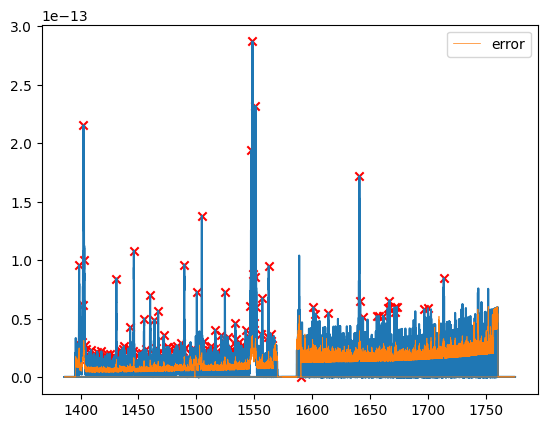

In [171]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

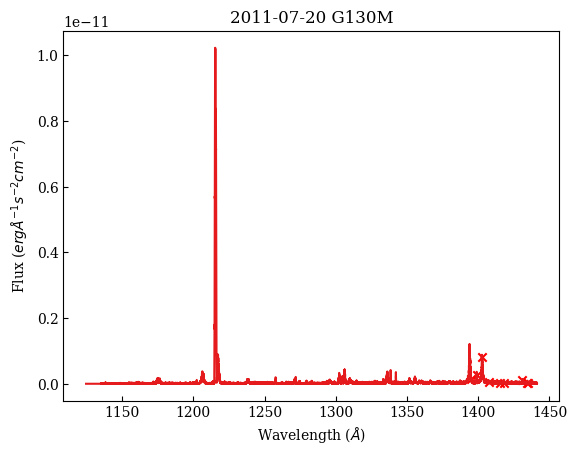

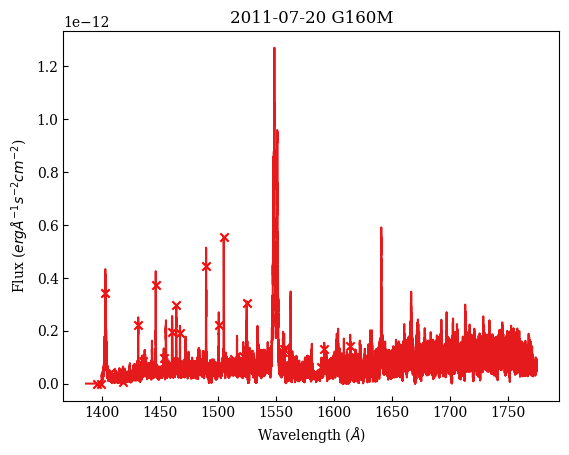

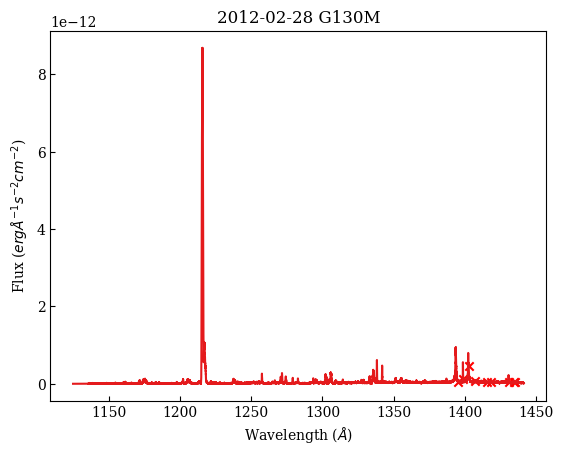

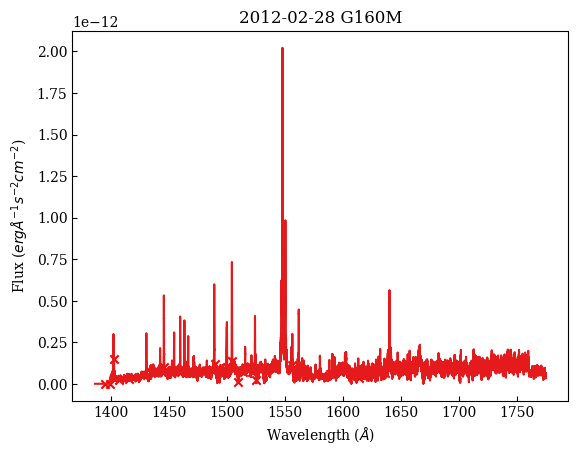

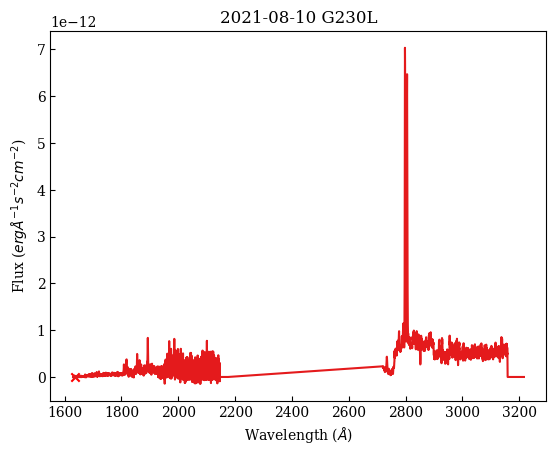

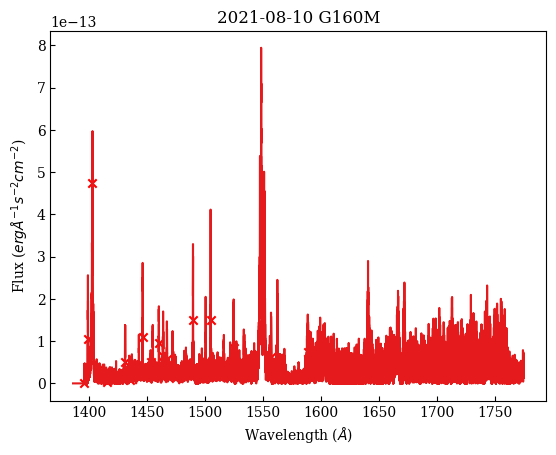

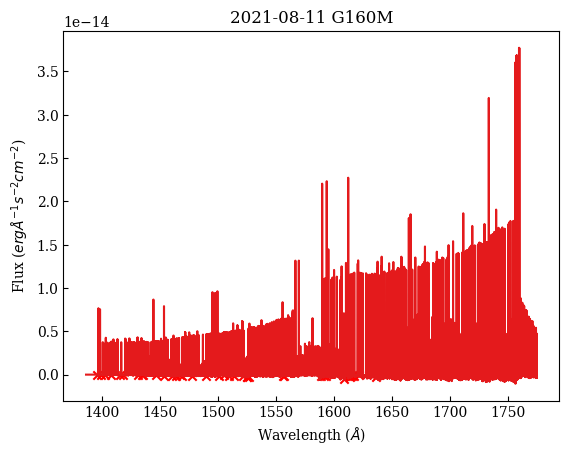

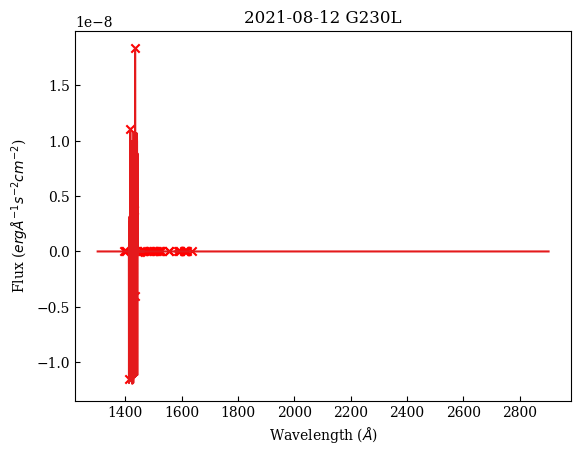

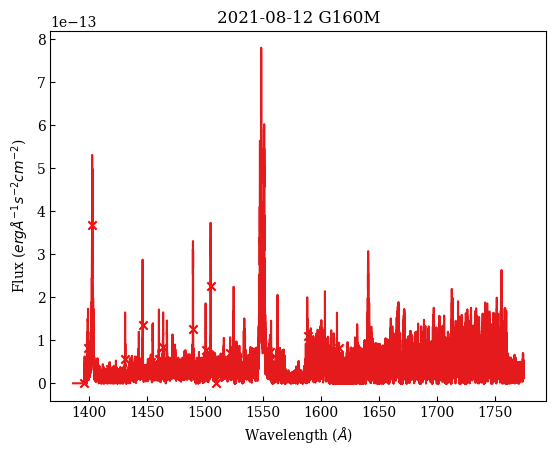

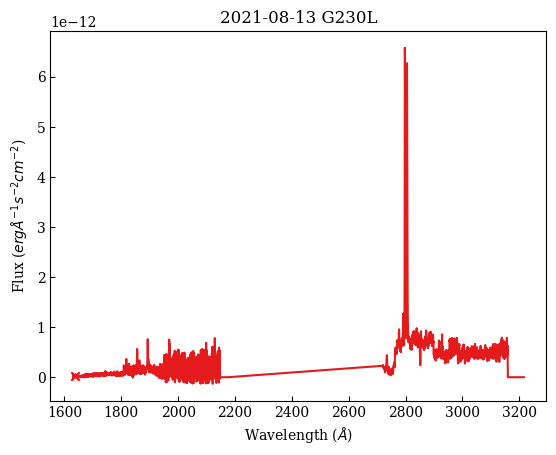

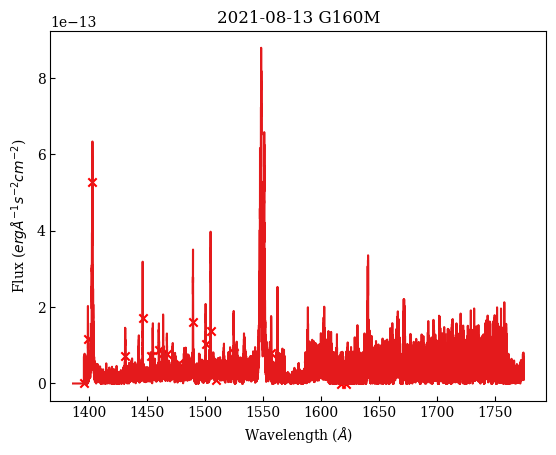

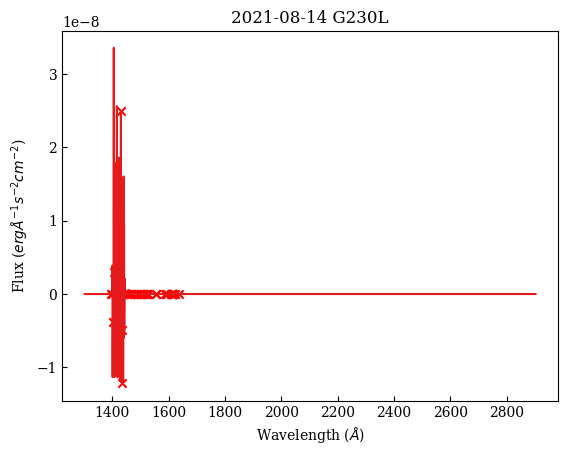

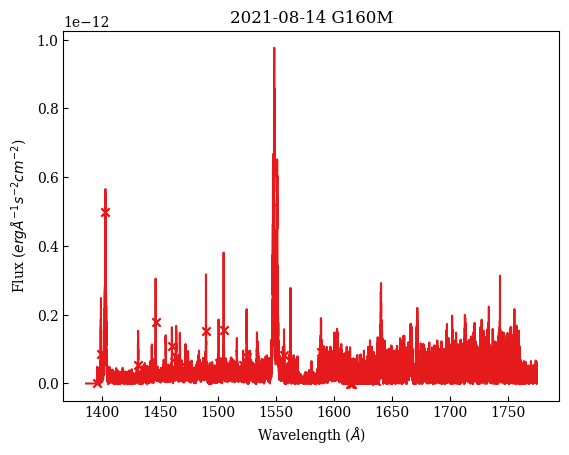

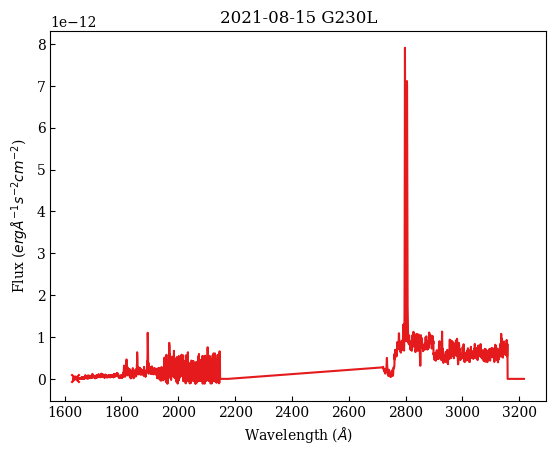

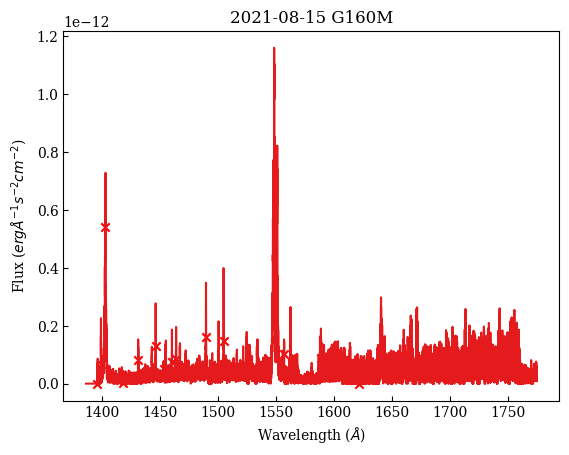

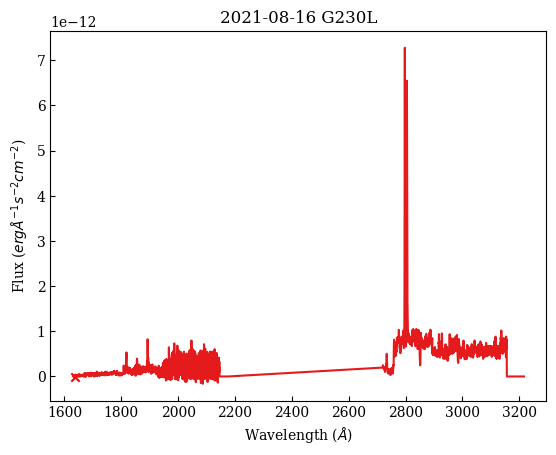

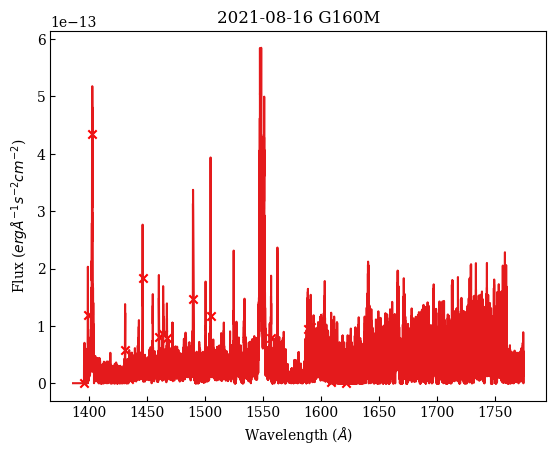

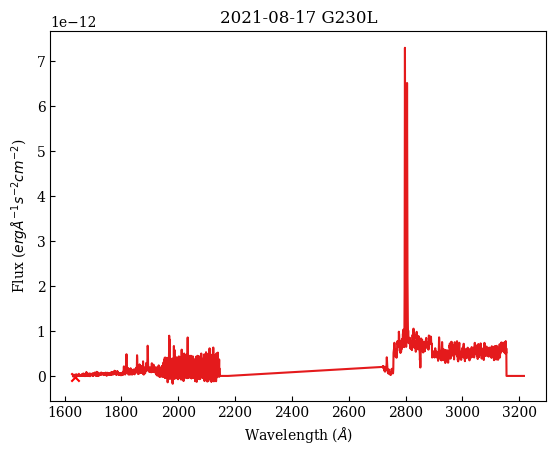

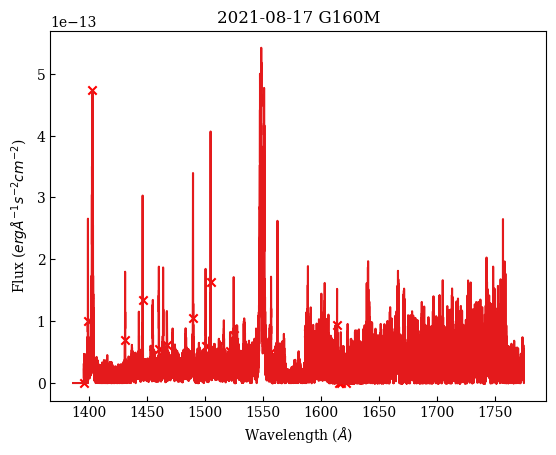

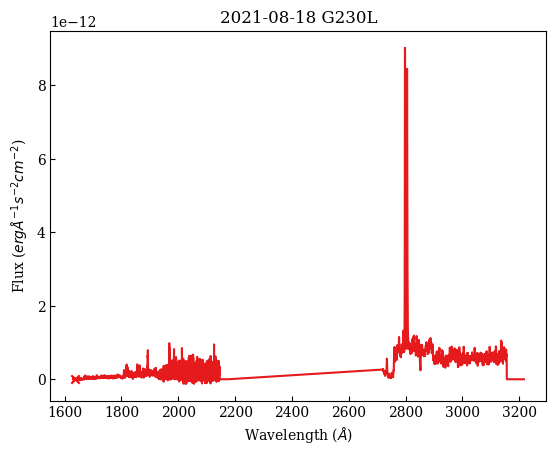

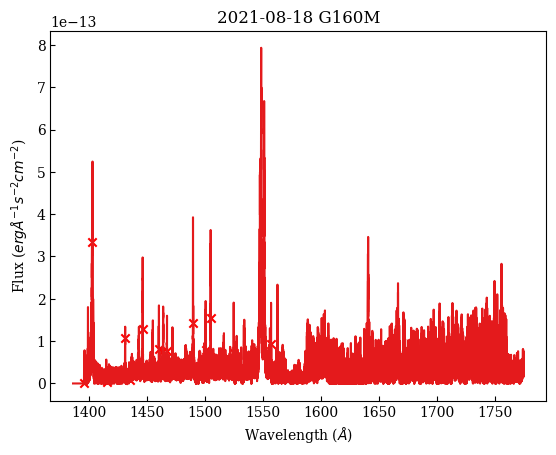

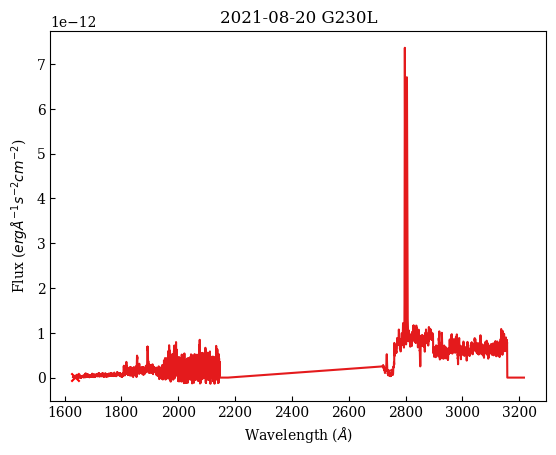

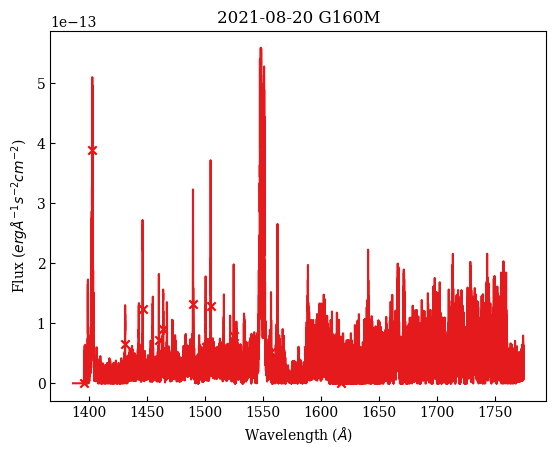

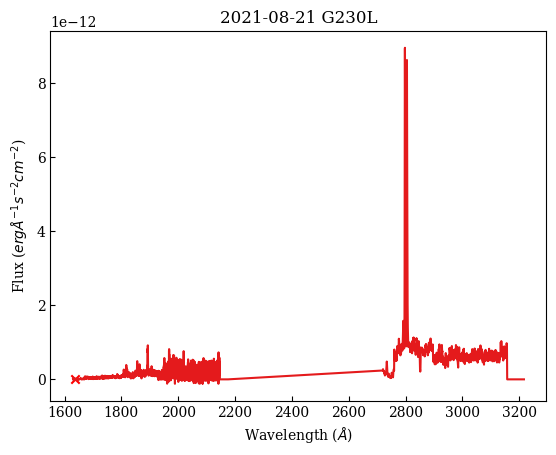

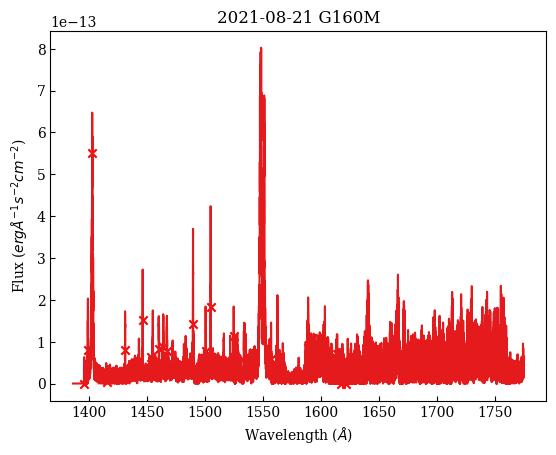

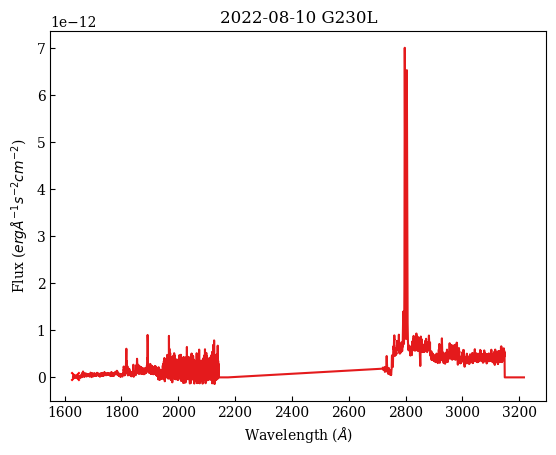

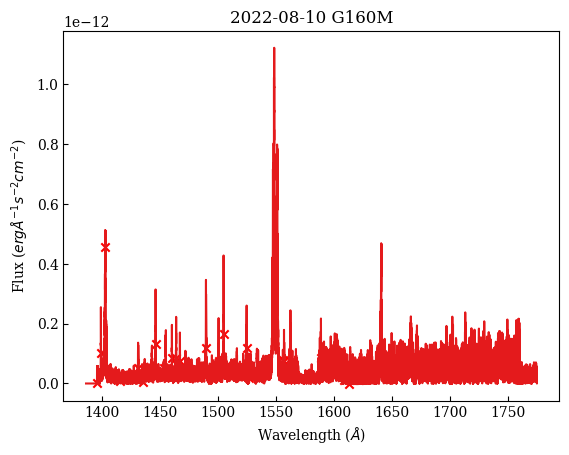

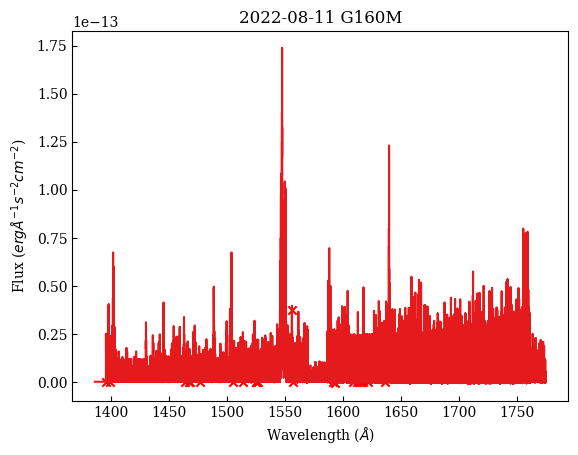

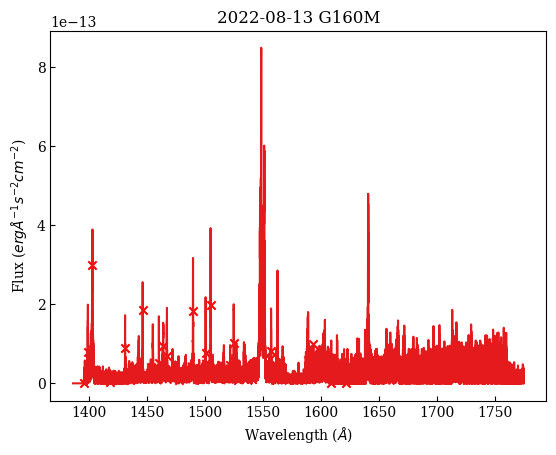

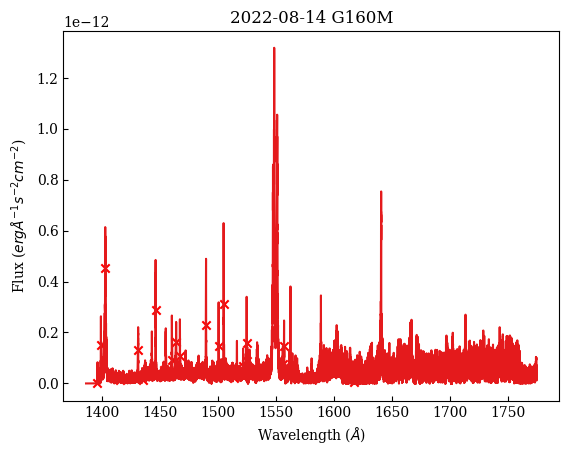

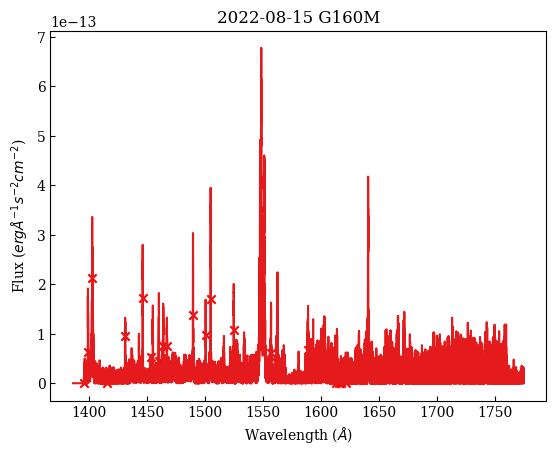

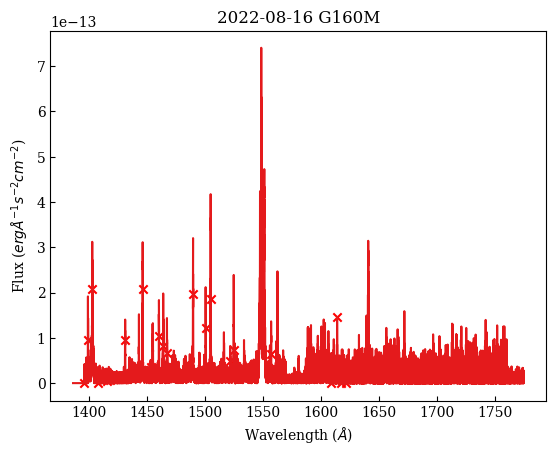

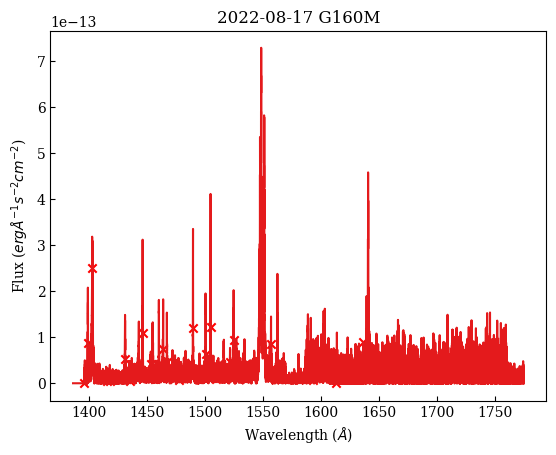

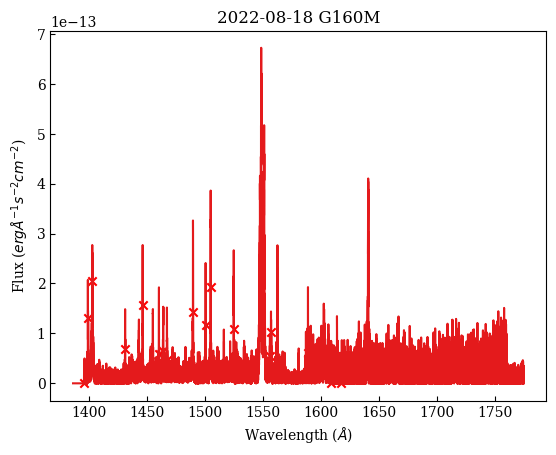

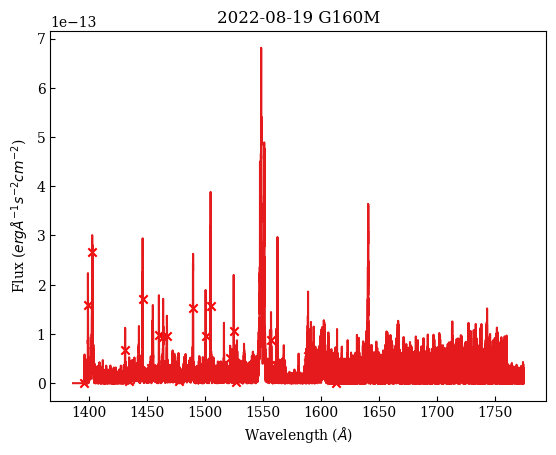

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f60402d15e0>>
Traceback (most recent call last):
  File "/mnt/c/Users/Prerana Kottapalli/Documents/GitHub/scripts_by_me/research24/astrotest/astro-venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


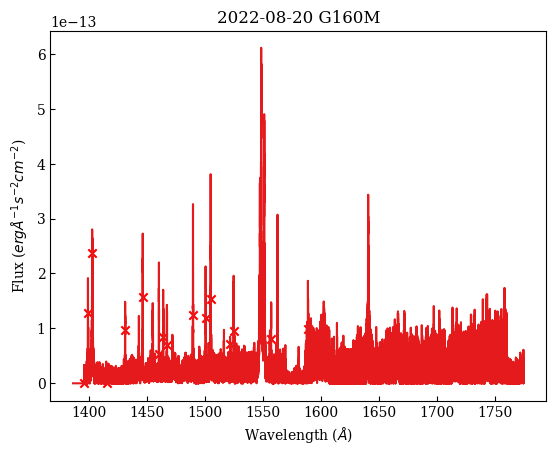

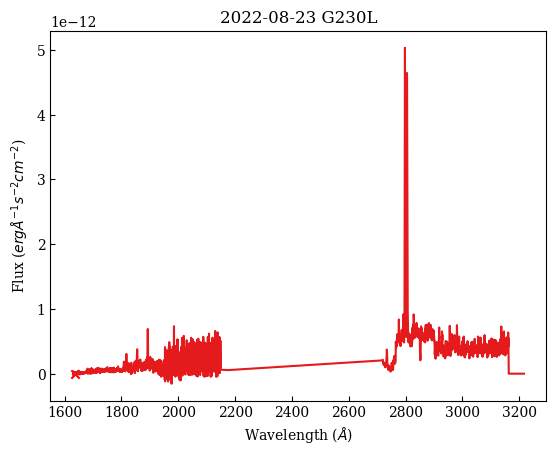

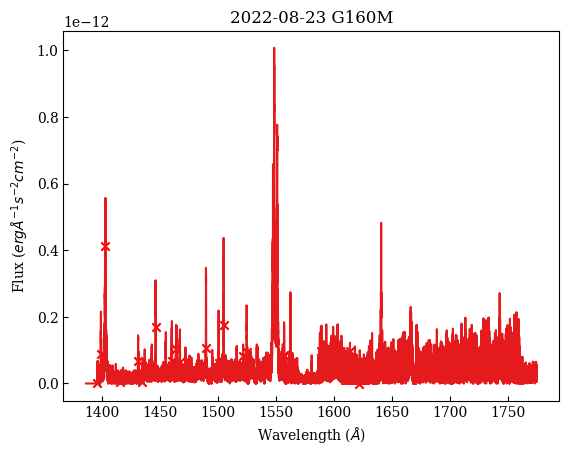

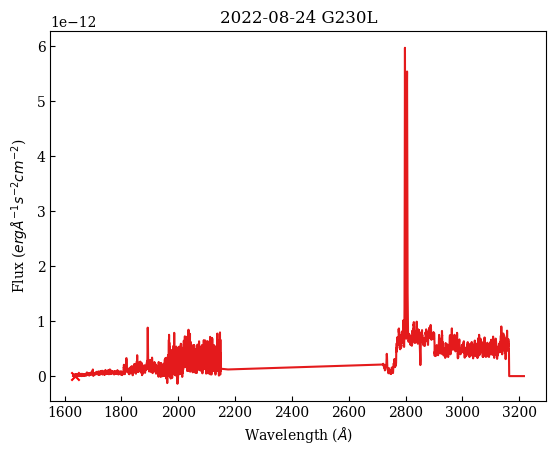

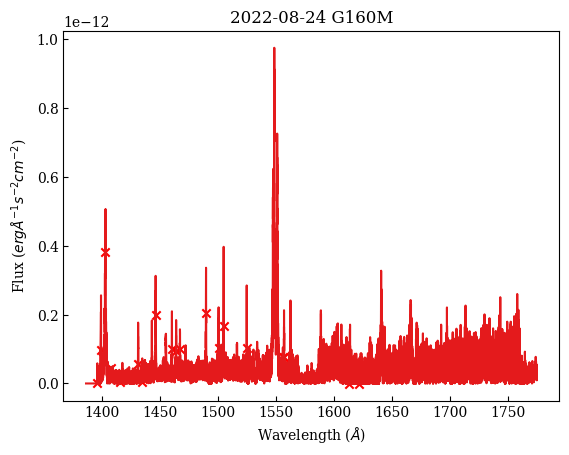

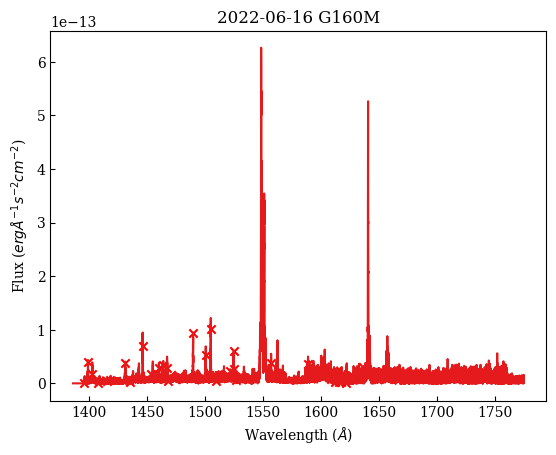

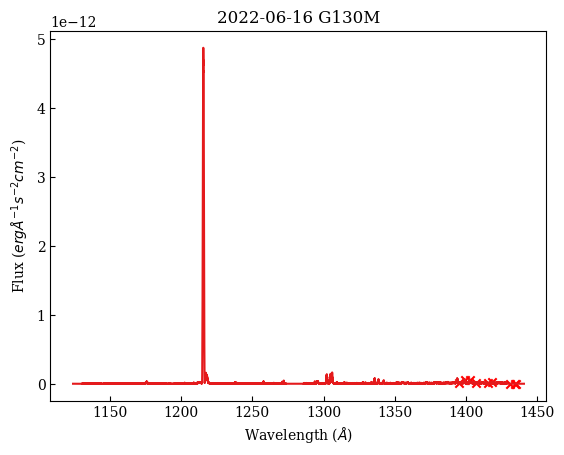

In [32]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [7]:
stacked_df = stacked_df[stacked_df['filter']!='G230L']
stacked_df = stacked_df[stacked_df["[nu', J']"].notna() & (stacked_df["[nu', J']"].apply(len) > 0)] #remove the spectra (coadded for one observation date) that don't have any H2 lines
stacked_df

obsdate filter                                         wavelength  \
0   2011-07-20  G130M  [1124.7185766387568 Angstrom, 1124.72853832954...   
1   2011-07-20  G160M  [1386.0412954067515 Angstrom, 1386.05353027634...   
2   2012-02-28  G130M  [1124.9096635174221 Angstrom, 1124.91962690073...   
3   2012-02-28  G160M  [1386.2769487823698 Angstrom, 1386.28918573199...   
5   2021-08-10  G160M  [1385.9946471407397 Angstrom, 1386.00688689571...   
6   2021-08-11  G160M  [1385.9941396590698 Angstrom, 1386.00637941009...   
8   2021-08-12  G160M  [1385.9934968299058 Angstrom, 1386.00573657483...   
10  2021-08-13  G160M  [1385.9931276253203 Angstrom, 1386.00536736705...   
12  2021-08-14  G160M  [1385.9926535426373 Angstrom, 1386.00489328013...   
14  2021-08-15  G160M  [1385.9921658835162 Angstrom, 1386.00440561677...   
16  2021-08-16  G160M  [1385.9916804390439 Angstrom, 1386.00392016811...   
18  2021-08-17  G160M  [1385.9912497641506 Angstrom, 1386.00348948963...   
20  2021-08-18  G160M  [1385.9909603061985 Angstrom, 1386.00320002882...   
22  2021-08-20  G160M  [1385.9903407572133 Angstrom, 1386.00258047415...   
24  2021-08-21  G160M  [1385.9900462627913 Angstrom, 1386.00228597737...   
26  2022-08-10  G160M  [1385.9951835939507 Angstrom, 1386.00742335376...   
27  2022-08-11  G160M  [1385.9945485462765 Angstrom, 1386.00678830049...   
28  2022-08-13  G160M  [1385.993493706029 Angstrom, 1386.005733450934...   
29  2022-08-14  G160M  [1385.9929259052471 Angstrom, 1386.00516564510...   
30  2022-08-15  G160M  [1385.9921428581877 Angstrom, 1386.00438259114...   
31  2022-08-16  G160M  [1385.9917161124404 Angstrom, 1386.00395584173...   
32  2022-08-17  G160M  [1385.9913361240272 Angstrom, 1386.00357584994...   
33  2022-08-18  G160M  [1385.9909696082839 Angstrom, 1386.00320933088...   
34  2022-08-19  G160M  [1385.9906740586073 Angstrom, 1386.00291377859...   
35  2022-08-20  G160M  [1385.9903499442378 Angstrom, 1386.00258966149...   
37  2022-08-23  G160M  [1385.9896587703408 Angstrom, 1386.00189848125...   
39  2022-08-24  G160M  [1385.9894779844765 Angstrom, 1386.00171769397...   
40  2022-06-16  G160M  [1386.075555441118 Angstrom, 1386.087795910712...   
41  2022-06-16  G130M  [1124.122411192166 Angstrom, 1124.132378553306...   

                                                 flux  \
0   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
2   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
3   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
5   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
6   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
8   [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
10  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
12  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
14  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
16  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
18  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
20  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
22  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
24  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
26  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
27  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
28  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
29  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
30  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
31  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
32  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
33  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
34  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
35  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
37  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
39  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
40  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
41  [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   

               

In [8]:
line_df = all_spectra.get_lines(stacked_df) #rearrange df by progressions, not obsdate
line_df

transition  labline     obsdate  \
0        [4,13]  1415.33  2011-07-20   
1        [4,13]  1415.33  2011-07-20   
2        [4,13]  1509.45  2011-07-20   
3        [4,13]  1613.99  2011-07-20   
4        [4,13]  1415.33  2012-02-28   
...         ...      ...         ...   
1010     [3,13]  1615.43  2022-08-23   
1011     [3,13]  1608.33  2022-08-24   
1012     [3,13]  1615.43  2022-08-24   
1013     [3,13]  1608.33  2022-06-16   
1014     [3,13]  1615.43  2022-06-16   

                                             wavelength  \
0     [1413.840275422512 Angstrom, 1413.850239964048...   
1     [1413.4963427774273 Angstrom, 1413.50857764702...   
2     [1507.6191945700343 Angstrom, 1507.63142943962...   
3     [1612.1496021754701 Angstrom, 1612.16184142035...   
4     [1413.8313372572309 Angstrom, 1413.84130349177...   
...                                                 ...   
1010  [1613.596769899303 Angstrom, 1613.609017434257...   
1011  [1606.4929711547893 Angstrom, 1606.50521868832...   
1012  [1613.5965406064772 Angstrom, 1613.60878814001...   
1013  [1606.4947618749995 Angstrom, 1606.50701016912...   
1014  [1613.5987724654758 Angstrom, 1613.61102075959...   

                                                   flux  \
0     [6.064983957019108e-14 erg / (Angstrom s cm2),...   
1     [1.77152580784021e-14 erg / (Angstrom s cm2), ...   
2     [5.512909732579766e-14 erg / (Angstrom s cm2),...   
3     [-2.6664306011989756e-16 erg / (Angstrom s cm2...   
4     [4.7407024144021164e-14 erg / (Angstrom s cm2)...   
...                                                 ...   
1010  [1.2234205076962212e-13 erg / (Angstrom s cm2)...   
1011  [2.9924169686618985e-14 erg / (Angstrom s cm2)...   
1012  [3.645414658613906e-14 erg / (Angstrom s cm2),...   
1013  [2.4744083826911735e-14 erg / (Angstrom s cm2)...   
1014  [6.554868223863442e-15 erg / (Angstrom s cm2),...   

                                                fluxerr  
0     [3.8630178126862933e-14 erg / (Angstrom s cm2)...  
1     [2.3773360887075196e-14 erg / (Angstrom s cm2)...  
2     [3.725933546817622e-14 erg / (Angstrom s cm2),...  
3     [5.158757557578166e-14 erg / (Angstrom s cm2),...  
4     [8.004566250431457e-15 erg / (Angstrom s cm2),...  
...                                                 ...  
1010  [3.910954022812035e-14 erg / (Angstrom s cm2),...  
1011  [2.694834295134379e-14 erg / (Angstrom s cm2),...  
1012  [2.620746555809019e-14 erg / (Angstrom s cm2),...  
1013  [1.0589358429720741e-14 erg / (Angstrom s cm2)...  
1014  [6.477701114083758e-15 erg / (Angstrom s cm2),...  

[1015 rows x 6 columns]

# Look for contaminated lines in the [0,1], [0,2], [1,4], [1,7] transitions

{'[0,3]', '[2,12]', '[0,2]', '[1,7]', '[4,13]', '[0,1]', '[3,16]', '[2,15]', '[1,4]', '[3,0]', '[4,4]', '[3,13]'}

In [9]:
exclude_lines = {
    "[0,1]": {
        "dates": ["2022-08-11", "2022-08-24", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2011-07-20", "2012-02-28", "2012-02-28", "2021-08-16", "2022-08-14", "2022-08-11", "2022-08-11"],
        "wavelengths": [1460.17, 1521.59, 1521.59, 1398.95, 1460.17, 1521.59, 1398.95, 1521.59, 1398.95, 1521.59, 1521.59, 1398.95, 1521.59]
    },
    "[0,2]": {
        "dates": ["2022-06-16", "2022-08-11", "2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2022-08-10", "2022-08-13", "All"],
        "wavelengths": [1525.15, 1463.83, 1525.15, 1402.65, 1463.83, 1525.15, 1402.65, 1525.15, 1525.15, 1525.15]
    },
    "[1,4]": {
        "dates": ["2022-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11"],
        "wavelengths": [1431.01, 1431.01, 1446.12, 1489.57, 1504.76]
    },
    "[1,7]": {
        "dates": ["All", "All", "2022-08-11", "2022-08-11", "2011-07-20", "2021-08-11", "2021-08-11", "2021-08-11", "2021-08-11", "2012-02-28", "2021-08-21", "2022-08-18"],
        "wavelengths": [1556.87, 1524.65, 1467.08, 1500.45, 1556.87, 1467.08, 1500.45, 1524.65, 1556.87, 1556.87, 1556.87, 1556.87]
    },
    "[2,12]": {
        'dates': ['2021-08-10', '2021-08-18', '2021-08-18', '2022-06-16', '2022-06-16', '2022-08-1', '2022-08-11', '2022-08-11', '2021-08-20', '2011-07-20', '2021-08-11', '2021-08-11', '2021-08-11', '2012-02-28', '2021-08-16', '2021-08-12', '2022-08-10', "All", "2022-08-11"],
        "wavelengths": [1453.10, 1555.89, 1588.8, 1453.1, 1555.89, 1453.1, 1555.89, 1588.8, 1555.89, 1588.8, 1453.1, 1555.89, 1588.8, 1555.89, 1453.1, 1555.89, 1453.1, 1434.54, 1453.1]
    }
}

In [10]:
# exclude bad/contaminated lines from coadding
bad_transitions = ['[3,0]', '[4,13]', '[3,13]', '[4,4]', '[2,15]', '[3,16]', '[4,0]']
bad_transitions_mask = ~line_df['transition'].isin(bad_transitions)
line_df_good = line_df[bad_transitions_mask]

contaminated = []
for transition in exclude_lines.keys():
    dates = exclude_lines[transition]['dates']
    lines_ex = exclude_lines[transition]['wavelengths']
    for d, w in zip(dates, lines_ex):
        if d == "All":
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)].tolist()
        else:
            exclude_idx = line_df_good.index[(line_df_good['transition']==transition)&(line_df_good['labline']==w)&(line_df_good['obsdate']==d)].tolist()
        contaminated.extend(exclude_idx)

line_df_good = line_df_good.drop(index=contaminated)

line_df_good = line_df_good[line_df_good['obsdate']!='2021-08-11']
#Drop duplicates
line_df_good = line_df_good[~line_df_good.duplicated(['obsdate', 'transition', 'labline'])]

# Diagnostics

In [76]:
def make_spectrum(row):
    spectrum = Spectrum1D(flux = row['flux'], spectral_axis=row['wavelength'], uncertainty=StdDevUncertainty(row['fluxerr']))
    #spectrum.spectral_axis.to(u.km/u.s, doppler_convention='optical', doppler_rest=row['labline']*u.AA)
    return spectrum

/tmp/ipykernel_11741/2120184872.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


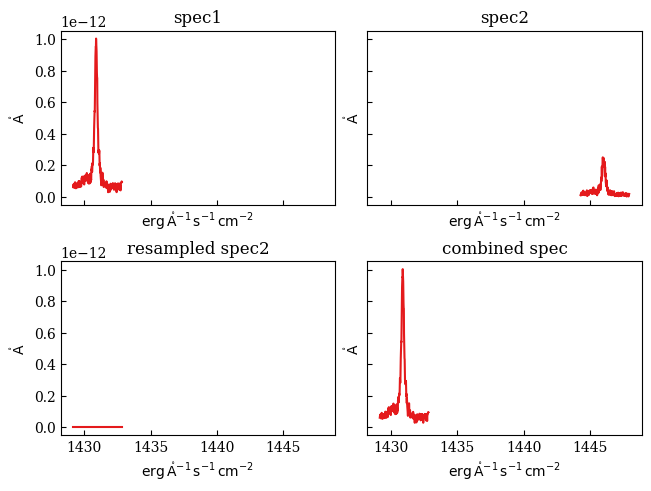

In [77]:
#Try checking what the wavelengths looks like once resampled, just try for two spectra.
resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
test = line_df_good[(line_df_good['obsdate']=='2022-08-20')&(line_df_good['transition']=='[1,4]')]
spec1 = make_spectrum(test.iloc[0])
spec2 = make_spectrum(test.iloc[1])
# spec1 = make_spectrum(stacked_df.iloc[0])
# spec2 = make_spectrum(stacked_df.iloc[1])

resampled_spec2 = resampler(spec2, spec1.spectral_axis)
#Once spec2 is resampled, the wavelengths of spec1 and spec2 are the same
combined_spec = spec1+resampled_spec2
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, layout='constrained')

axs[0,0].plot(spec1.spectral_axis, spec1.flux)
axs[0,1].plot(spec2.spectral_axis, spec2.flux)
axs[1,0].plot(resampled_spec2.spectral_axis, resampled_spec2.flux)
axs[1,1].plot(combined_spec.spectral_axis, combined_spec.flux)

axs[0,0].set_title('spec1')
axs[0,1].set_title('spec2')
axs[1,0].set_title('resampled spec2')
axs[1,1].set_title('combined spec')

for ax in np.ravel(axs):
    ax.set_xlabel(u.format.Latex().to_string(spec1.flux.unit, fraction=False))
    ax.set_ylabel(u.format.Latex().to_string(spec1.spectral_axis.unit, fraction=False))
fig.show()

In [75]:
#convert both lines to velocity space first
spec1v = all_spectra.radial_velocity(test.iloc[0]['wavelength'], test.iloc[0]['labline'])
spec2v = all_spectra.radial_velocity(test.iloc[1]['wavelength'], test.iloc[1]['labline'])
spec1flux = test.iloc[0]['flux']
spec2flux = test.iloc[1]['flux']
spec1fluxerr = test.iloc[0]['fluxerr']
spec2fluxerr = test.iloc[1]['fluxerr']
#Then cross correlate to find how the second should be shifted to the first
f=interp1d(spec2v, spec2flux, kind='linear', fill_value=0, bounds_error=False)
resampled_spec2flux = f(spec1v) #This is then the extrapolated flux after resampling
resampled_spec2v = spec1v
#Then add the fluxes together
coadded_flux = spec1flux.value+resampled_spec2flux
coadded_velocity = spec1v

#Then propagate errors
error = np.sqrt(spec1fluxerr**2 + spec2fluxerr**2)

#plot
fig, axs = plt.subplots(2,2,sharex=True, sharey=True, layout='constrained')

axs[0,0].plot(spec1v, spec1flux)
axs[0,1].plot(spec2v, spec2flux)
axs[1,0].plot(resampled_spec2v, resampled_spec2flux)
axs[1,1].plot(coadded_velocity, coadded_flux)

axs[0,0].set_title('spec1')
axs[0,1].set_title('spec2')
axs[1,0].set_title('resampled spec2')
axs[1,1].set_title('combined spec')

#for ax in np.ravel(axs):
fig.supylabel(u.format.Latex().to_string(all_spectra.flux_units, fraction=False))
fig.supxlabel(u.format.Latex().to_string(u.km/u.s, fraction=False))
fig.show()

/tmp/ipykernel_11741/3417691443.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [134]:
#coadd all spectral lines in the same progression for better SNR
prog_df = all_spectra.coaddwave(line_df_good, columns=['obsdate', 'transition'], velocity=True)
prog_df

obsdate transition                                         wavelength  \
0    2021-08-13      [0,3]  [1393.361452150926 Angstrom, 1393.373691892663...   
1    2021-08-10      [0,3]  [1466.5495060766177 Angstrom, 1466.56175467301...   
2    2021-08-18      [0,3]  [1466.5578768825458 Angstrom, 1466.57012544660...   
3    2022-06-16      [0,3]  [1466.54896698962 Angstrom, 1466.561216297604 ...   
4    2021-08-15      [0,3]  [1466.5469112432431 Angstrom, 1466.55915981792...   
..          ...        ...                                                ...   
143  2022-08-18      [0,2]  [1461.9891765429932 Angstrom, 1462.00142510702...   
144  2021-08-17      [0,2]  [1400.8135573247532 Angstrom, 1400.82579705023...   
145  2022-08-13      [0,2]  [1461.9918320635643 Angstrom, 1462.00408064989...   
146  2022-08-17      [0,2]  [1461.9895583139005 Angstrom, 1462.00180688124...   
147  2022-08-20      [0,2]  [1461.9885037500321 Angstrom, 1462.00075230872...   

                                                  flux  \
0    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1    [2.6582631463336287e-09 erg / (Angstrom s cm2)...   
2    [4.8598197746272346e-09 erg / (Angstrom s cm2)...   
3    [3.0463131741859097e-09 erg / (Angstrom s cm2)...   
4    [4.878058639523239e-09 erg / (Angstrom s cm2),...   
..                                                 ...   
143  [2.2513561216096542e-09 erg / (Angstrom s cm2)...   
144  [1.3876859730754809e-11 erg / (Angstrom s cm2)...   
145  [2.4956723648155793e-09 erg / (Angstrom s cm2)...   
146  [2.201810586421509e-09 erg / (Angstrom s cm2),...   
147  [3.864211045991475e-09 erg / (Angstrom s cm2),...   

                                               fluxerr  \
0    [0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...   
1    [1.2825507804775605e-14 erg / (Angstrom s cm2)...   
2    [1.7402503061500313e-14 erg / (Angstrom s cm2)...   
3    [6.172714986437967e-15 erg / (Angstrom s cm2),...   
4    [1.7201545150234512e-14 erg / (Angstrom s cm2)...   
..                                                 ...   
143  [1.5227250916943796e-14 erg / (Angstrom s cm2)...   
144  [1.536465089819808e-14 erg / (Angstrom s cm2),...   
145  [1.5566065314701958e-14 erg / (Angstrom s cm2)...   
146  [1.510995361024994e-14 erg / (Angstrom s cm2),...   
147  [1.7802805813204683e-14 erg / (Angstrom s cm2)...   

                                              velocity  
0    [-395.05646418043307 km / s, -392.426459693181...  
1    [-375.76270420315456 km / s, -373.261981083160...  
2    [-374.05368651398624 km / s, -371.552969997834...  
3    [-375.87276639103504 km / s, -373.371897991441...  
4    [-376.29247590923217 km / s, -373.791757223386...  
..                                                 ...  
143  [-377.0007370528645 km / s, -374.4922305204442...  
144  [-392.50822627764313 km / s, -389.892194204112...  
145  [-376.45688630566787 km / s, -373.948375205466...  
146  [-376.9225503517754 km / s, -374.4140431403020...  
147  [-377.13852508530863 km / s, -374.630019645723...  

[148 rows x 6 columns]

# Plot coadded lines

In [34]:
prog_df = all_spectra.coaddvel(line_df_good, columns=['transition', 'obsdate'])
prog_df

transition     obsdate                                         wavelength  \
0        [0,1]  2011-07-20  [1458.3371398422792 Angstrom, 1458.34937471187...   
1        [0,1]  2012-02-28  [1458.3403451277009 Angstrom, 1458.35258207732...   
2        [0,1]  2021-08-10  [1397.1083446555845 Angstrom, 1397.12058441055...   
3        [0,1]  2021-08-12  [1397.1194249726605 Angstrom, 1397.13166471759...   
4        [0,1]  2021-08-13  [1397.1190528641503 Angstrom, 1397.13129260588...   
..         ...         ...                                                ...   
142     [2,12]  2022-08-19  [1451.265100728928 Angstrom, 1451.277340448911...   
143     [2,12]  2022-08-20  [1451.2647620994849 Angstrom, 1451.27700181674...   
144     [2,12]  2022-08-23  [1451.2640370666647 Angstrom, 1451.27627677757...   
145     [2,12]  2022-08-24  [1451.2638487281617 Angstrom, 1451.27608843765...   
146     [2,12]  2022-06-16  [1586.95873275119 Angstrom, 1586.9709810453114...   

                                                  flux  \
0    [2.9000318751498025e-14 erg / (Angstrom s cm2)...   
1    [8.471138387321403e-14 erg / (Angstrom s cm2),...   
2    [1.5845557287194555e-14 erg / (Angstrom s cm2)...   
3    [2.3908858680172583e-14 erg / (Angstrom s cm2)...   
4    [1.873849774845978e-14 erg / (Angstrom s cm2),...   
..                                                 ...   
142  [1.335067945877892e-14 erg / (Angstrom s cm2),...   
143  [2.11873068547441e-14 erg / (Angstrom s cm2), ...   
144  [4.5865976007253636e-14 erg / (Angstrom s cm2)...   
145  [3.432365788738363e-14 erg / (Angstrom s cm2),...   
146  [5.122244840329658e-15 erg / (Angstrom s cm2),...   

                                               fluxerr  \
0    [2.806122488372946e-14 erg / (Angstrom s cm2),...   
1    [8.32409544433221e-15 erg / (Angstrom s cm2), ...   
2    [7.168589017246846e-15 erg / (Angstrom s cm2),...   
3    [7.763175674237009e-15 erg / (Angstrom s cm2),...   
4    [7.12562340100781e-15 erg / (Angstrom s cm2), ...   
..                                                 ...   
142  [1.454532406828468e-14 erg / (Angstrom s cm2),...   
143  [1.5028406636233252e-14 erg / (Angstrom s cm2)...   
144  [1.8002982931799023e-14 erg / (Angstrom s cm2)...   
145  [1.5668620221410423e-14 erg / (Angstrom s cm2)...   
146  [1.0044985441668412e-14 erg / (Angstrom s cm2)...   

                                              velocity  
0    [-376.31073906012375 km / s, -373.798756462810...  
1    [-375.65265103259065 km / s, -373.140241377104...  
2    [-394.66341362535104 km / s, -392.040456244111...  
3    [-392.2889216909491 km / s, -389.6659664614886...  
4    [-392.3686638725232 km / s, -389.7457093276109...  
..                                                 ...  
142  [-378.5623581701537 km / s, -376.0371529268840...  
143  [-378.63222160220437 km / s, -376.107016920494...  
144  [-378.7818048182782 km / s, -376.2566014464359...  
145  [-378.82066137512123 km / s, -376.295458295434...  
146  [-347.4307869811528 km / s, -345.1196425948305...  

[147 rows x 6 columns]

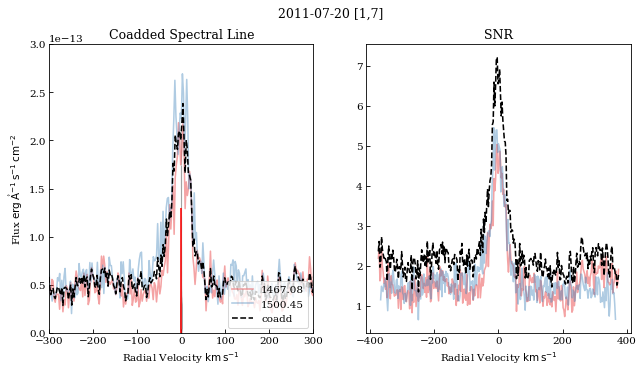

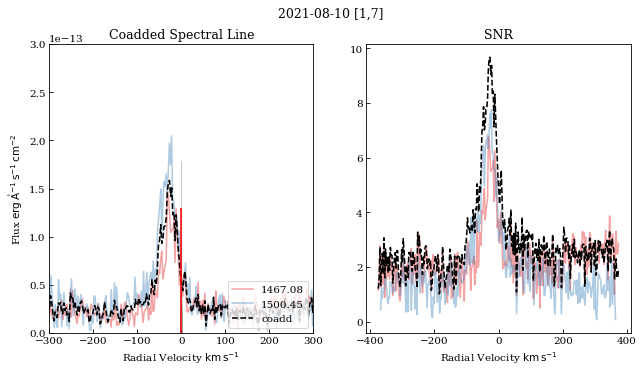

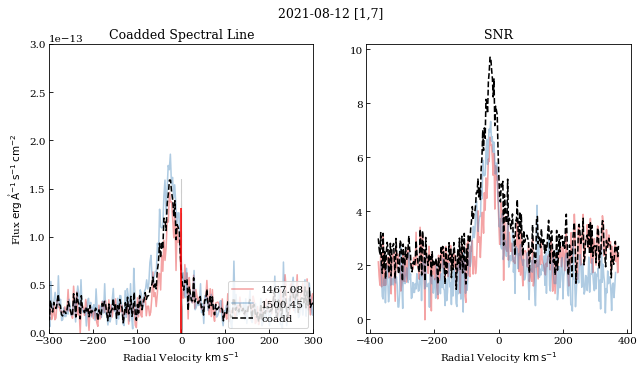

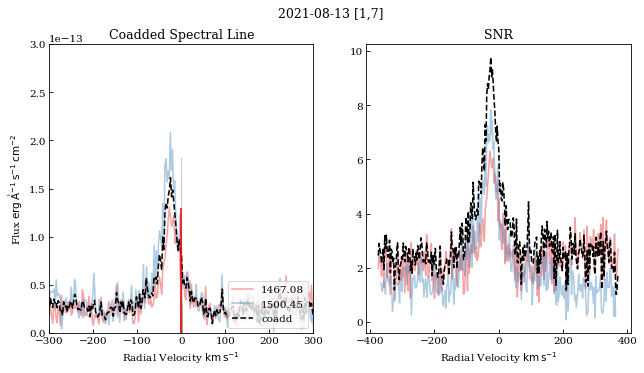

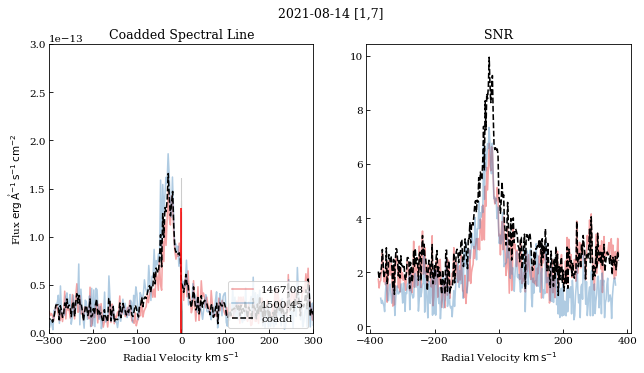

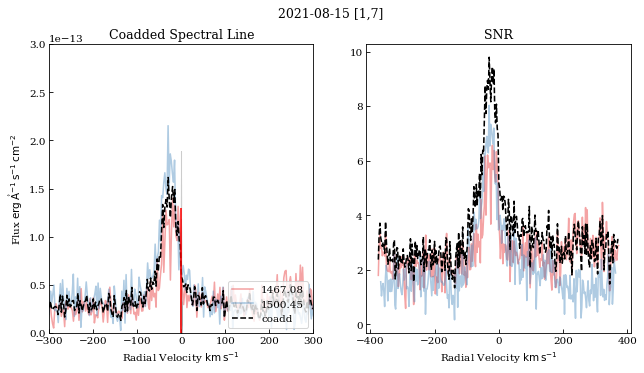

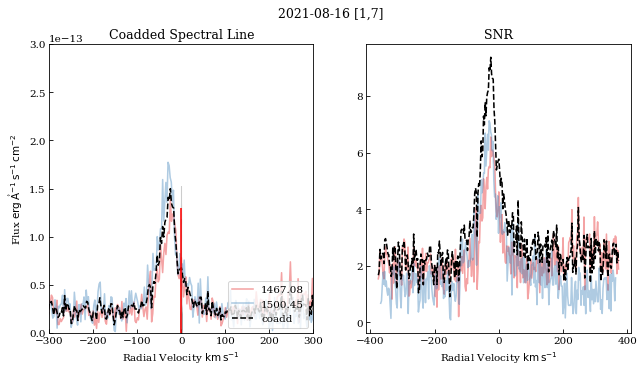

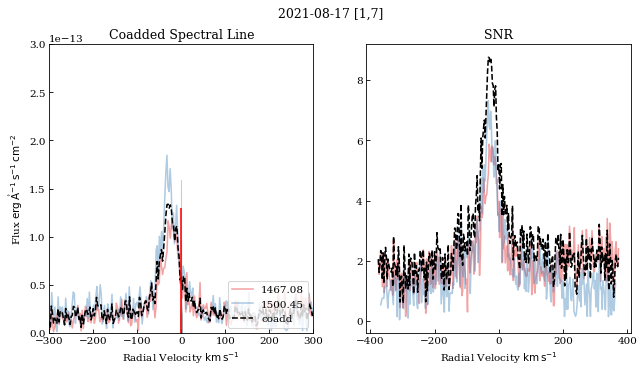

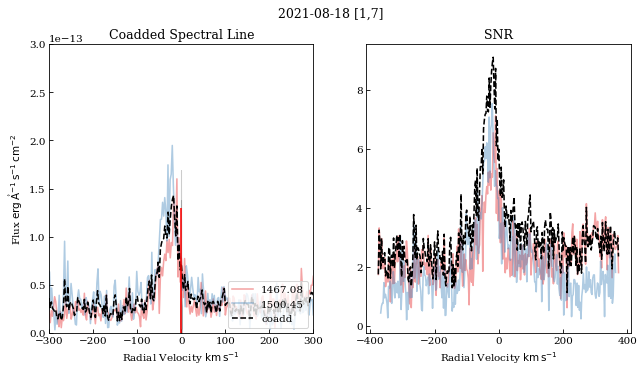

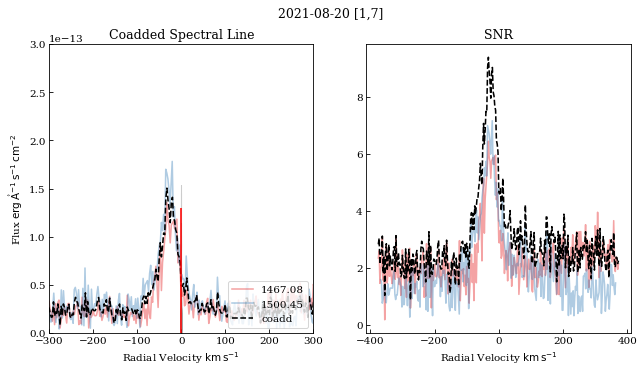

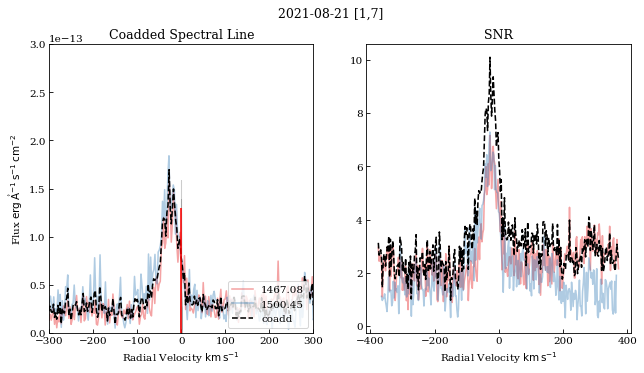

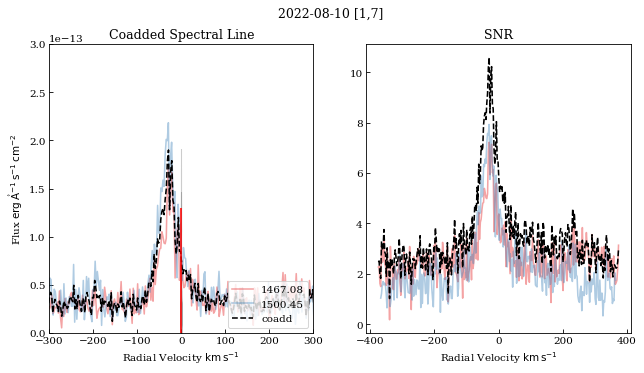

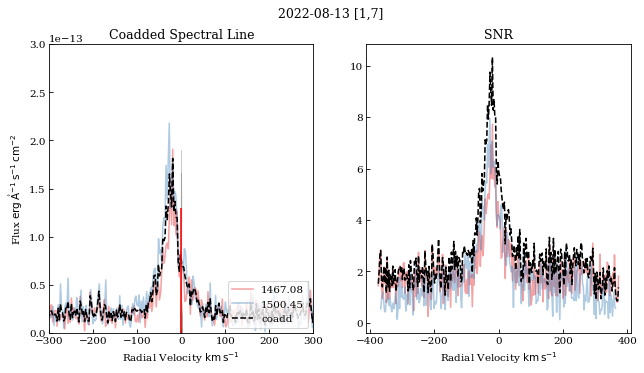

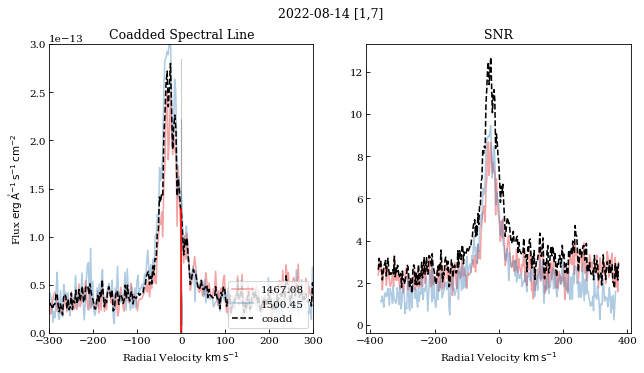

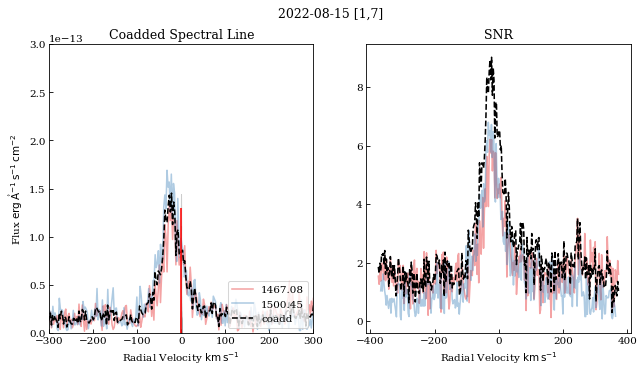

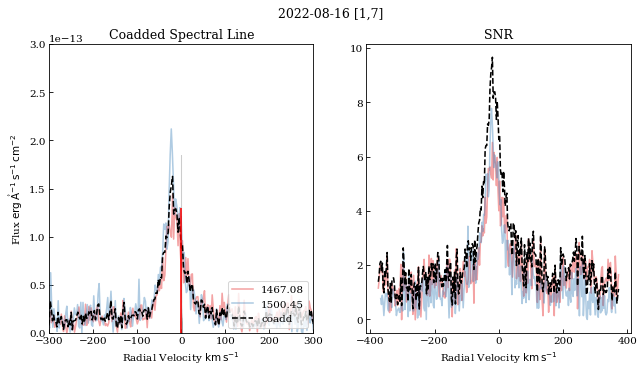

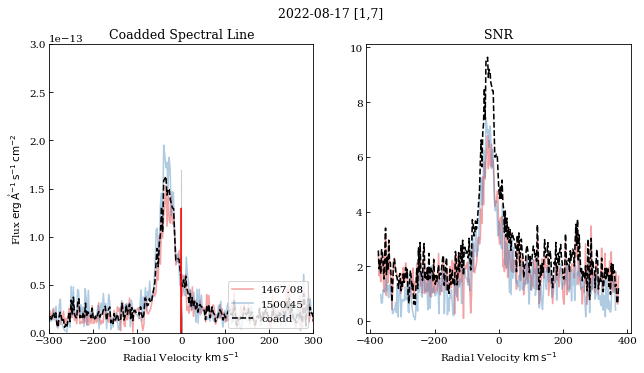

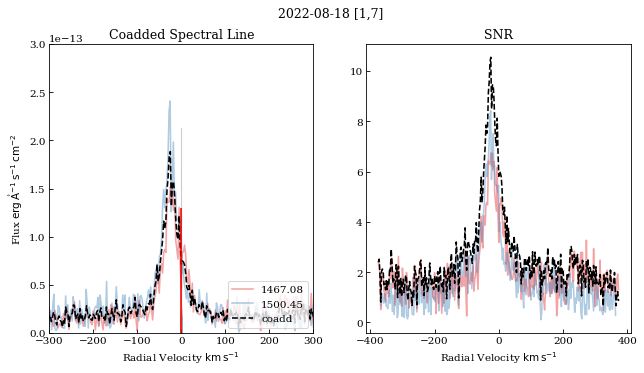

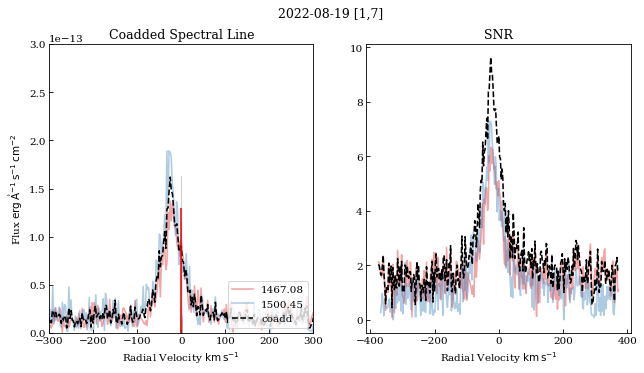

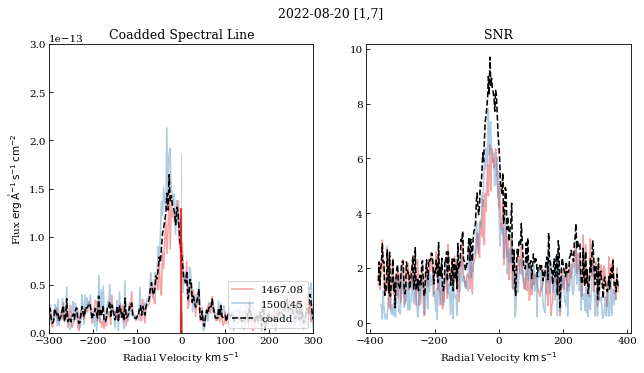

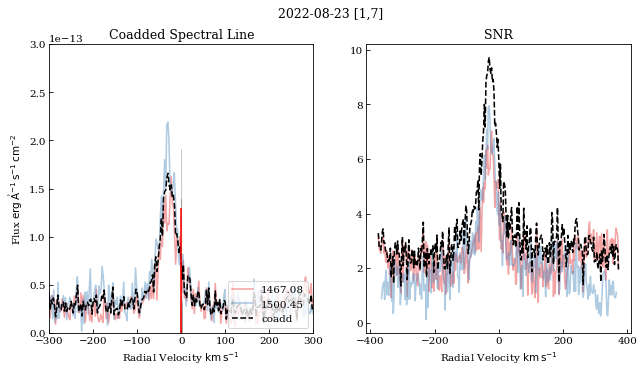

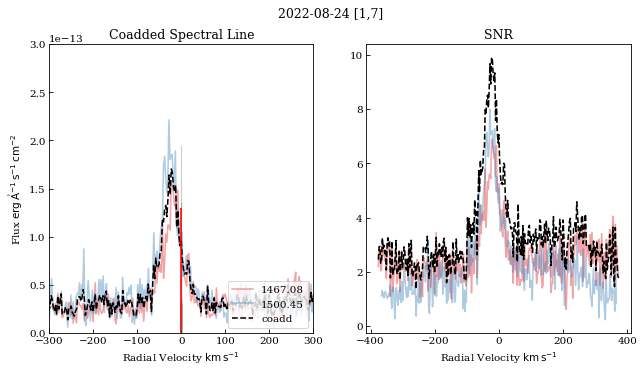

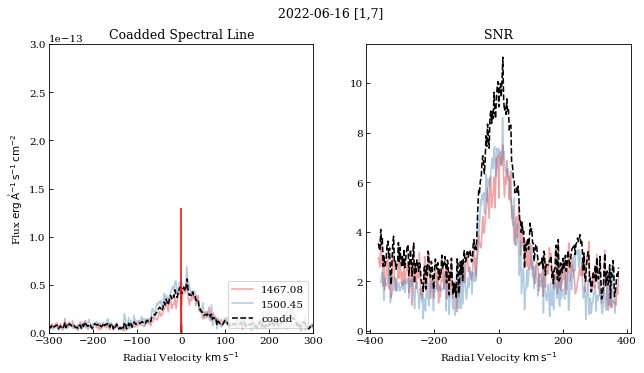

In [ ]:
ibm_colors = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
#for transition_plot in prog_df['transition'].unique():
for transition_plot in ['[1,7]']:
    mask = prog_df['transition']==transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        fig.suptitle(row_prog['obsdate']+' '+transition_plot)
        coadd_lines = line_df_good[(line_df_good['transition']==transition_plot) & (line_df_good['obsdate']==row_prog['obsdate'])]
        for _, row_line in coadd_lines.iterrows():
            velocity = all_spectra.radial_velocity(row_line['wavelength'], row_line['labline'])
            ax[0].fill_between(row_line['flux'].value+row_line['fluxerr'].value, row_line['flux'].value-row_line['fluxerr'].value, alpha=0.2, color='black')
            ax[0].plot(velocity, row_line['flux'], alpha=0.4, label=row_line['labline'])
            ax[1].plot(velocity, row_line['flux']/row_line['fluxerr'], alpha=0.4, label=row_line['labline'])

            
        ax[0].plot(row_prog['velocity'], row_prog['flux'], c='black', ls='--', label='coadd')
        ax[0].vlines(0, 0,1.3e-13, 'r')

        ax[1].plot(row_prog['velocity'], row_prog['flux'].value/row_prog['fluxerr'].value, c='black', ls='--', label='coadd')
        
        ax[0].set_xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row_prog['velocity'].unit, fraction=False))
        ax[1].set_xlabel('Radial Velocity'+' '+u.format.Latex().to_string(row_prog['velocity'].unit, fraction=False))
        
        ax[0].set_ylabel('Flux'+' '+u.format.Latex().to_string(row_prog['flux'].unit, fraction=False))
        ax[0].text(0.05, 0.95, f'Num lines = {len(coadd_lines)}', transform=plt.gca().transAxes, verticalalignment='top')
        ax[0].set_ylim(0, 3e-13)
        ax[0].set_xlim(-300,300)
        ax[0].legend(loc='lower right')
        ax[0].set_title('Coadded Spectral Line')
        ax[1].set_title('SNR')
        plt.show()

# Fit a single Gaussian distribution to each line

In [12]:
def gaussian(x, amp, sig, cen, bgl):
    y = amp * np.exp(-((x - cen)**2.0)/(2.0 * (sig**2.0))) + bgl
    return y

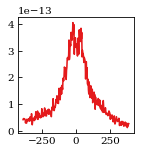

In [13]:
exampleLine = prog_df.iloc[30]
plt.figure(figsize=(2,2))
plt.plot(exampleLine['velocity'], exampleLine['flux'])
plt.show()

In [50]:
lineModel = Model(gaussian)
lineParam = lineModel.make_params(amp=max(exampleLine['flux'].value),
                                sig=np.min(abs(exampleLine['velocity'].value[np.argmax(exampleLine['flux'])]-exampleLine['velocity'].value[np.isclose(exampleLine['flux'].value, (max(exampleLine['flux'].value)-np.median(exampleLine['flux'].value[0:25]))/(2*2*np.sqrt(2*np.log(2))), atol=1e-14)])),
                                cen=0,
                                bgl=0.3e-13
                                )

#set parameter limits
lineParam['amp'].min = 0
lineParam['amp'].max = 1.5*max(exampleLine['flux'].value+exampleLine['fluxerr'].value)
#lineParam['amp'].set(0.95*max(exampleLine['flux'].value), vary=False)
lineParam['sig'].min = 0.0
lineParam['sig'].max = 1.3 * lineParam['sig'].value
lineParam['cen'].min = -50 #u.km/u.s
lineParam['cen'].max = 50 #u.km/u.s
lineParam['bgl'].min = 0
lineParam['bgl'].max = 0.25

In [51]:
#fit the code
lineFit = lineModel.fit(exampleLine['flux'].value, lineParam, x=exampleLine['velocity'].value, weights=1/exampleLine['fluxerr'].value, scale_covar=False)
print(lineFit.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 300
    # variables        = 4
    chi-square         = 869.188741
    reduced chi-square = 2.93644845
    Akaike info crit   = 327.133346
    Bayesian info crit = 341.948476
    R-squared          = 1.00000000
[[Variables]]
    amp:  2.8145e-13 +/- 3.3915e-15 (1.21%) (init = 4.053146e-13)
    sig:  88.6121902 +/- 1.04621824 (1.18%) (init = 136.0338)
    cen:  0.42683475 +/- 0.95511251 (223.77%) (init = 0)
    bgl:  3.2807e-14 +/- 7.3911e-17 (0.23%) (init = 3e-14)
[[Correlations]] (unreported correlations are < 0.100)
    C(sig, bgl) = -0.5224
    C(amp, sig) = -0.5107


In [ ]:
np.min(abs(exampleLine['velocity'].value[np.argmax(exampleLine['flux'])]-exampleLine['velocity'].value[np.isclose(exampleLine['flux'].value, (max(exampleLine['flux'].value)-np.median(exampleLine['flux'].value[0:25]))/(2*2*np.sqrt(2*np.log(2))), atol=1e-14)]))

np.float64(136.03375419499858)

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:14: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2059/890485577.py:12: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0.05,0.95, f'Reduced ${{\chi^2}}$={bestRed:0.2}', transform=ax.transAxes, verticalalignment='top')
/tmp/ipykernel_2059/890485577.py:14: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05,0.95-(0.051*(i+1)), f'{bestPar[param].name}={bestPar[param].value:0.2} $\pm$ {bestPar[param].stderr:0.2}', transform=ax.transAxes, verticalalignment='top')
/tmp/ipykernel_2059/890485577.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


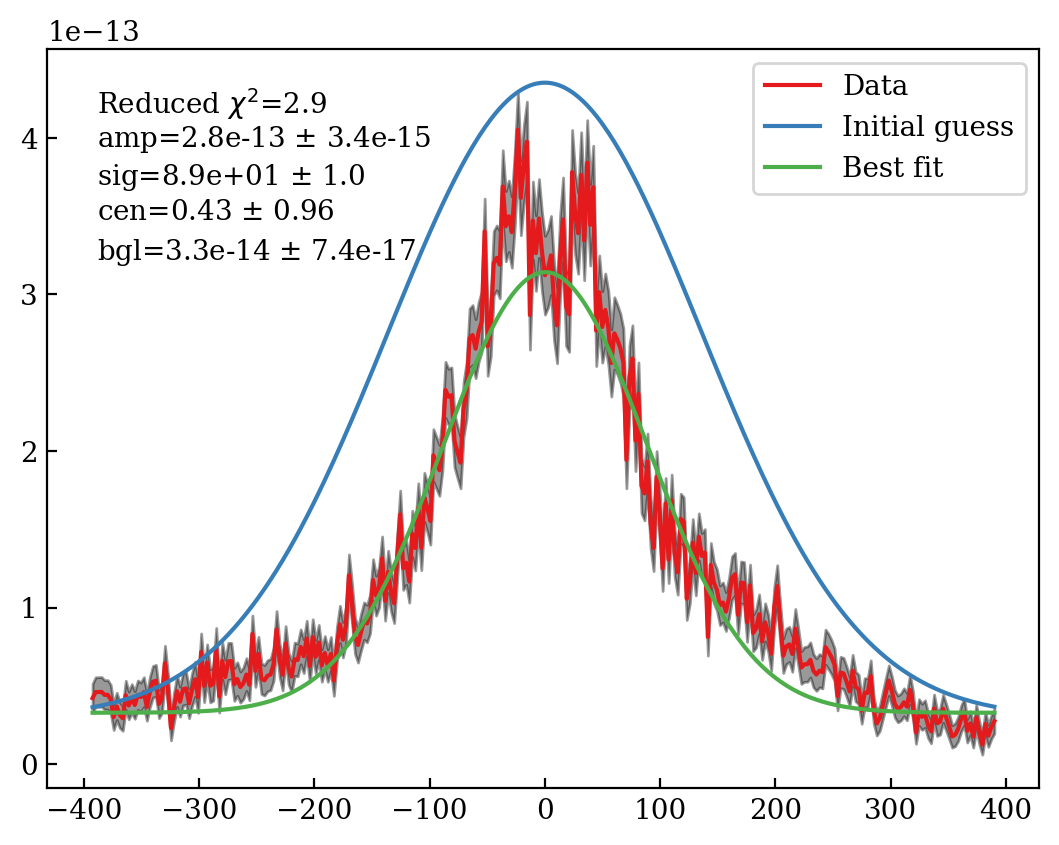

In [52]:
initFit = lineFit.init_fit #the initial fit array, generated from our initial guesses
bestFit = lineFit.best_fit #the best fit array, no need to calculate manually with gaussian(wavlen, *params)
bestChi = lineFit.chisqr #again, no need to calculate this manually as we had to with curve_fit
bestRed = lineFit.redchi #same as above
bestPar = lineFit.params
x = exampleLine['velocity']
fig, ax = plt.subplots(dpi=200)
ax.plot(x, exampleLine['flux'], label='Data')
ax.plot(x, initFit, label='Initial guess')
ax.plot(x, bestFit, label='Best fit')
ax.fill_between(x.value, exampleLine['flux'].value-exampleLine['fluxerr'].value, exampleLine['flux'].value+exampleLine['fluxerr'].value, color='black', alpha=0.4)
ax.text(0.05,0.95, f'Reduced ${{\chi^2}}$={bestRed:0.2}', transform=ax.transAxes, verticalalignment='top')
for i, param in enumerate(bestPar):
     ax.text(0.05,0.95-(0.051*(i+1)), f'{bestPar[param].name}={bestPar[param].value:0.2} $\pm$ {bestPar[param].stderr:0.2}', transform=ax.transAxes, verticalalignment='top')
ax.legend()
fig.show()


In [64]:
max(row_prog['flux'].value+row_prog['fluxerr'].value)-max(row_prog['flux'].value)

np.float64(3.869862577736483e-15)

<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:43: SyntaxWarning: invalid escape sequence '\c'
<>:45: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2059/1948362381.py:43: SyntaxWarning: invalid escape sequence '\c'
  ax.text(0.05,0.95, f'Reduced ${{\chi^2}}$={bestRed:0.2}', transform=ax.transAxes, verticalalignment='top')
/tmp/ipykernel_2059/1948362381.py:45: SyntaxWarning: invalid escape sequence '\p'
  ax.text(0.05,0.95-(0.051*(i+1)), f'{bestPar[param].name}={bestPar[param].value:0.2} $\pm$ {bestPar[param].stderr:0.2}', transform=ax.transAxes, verticalalignment='top')
/tmp/ipykernel_2059/1948362381.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_2059/1948362381.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too muc

ValueError: Parameter 'amp' has min == max

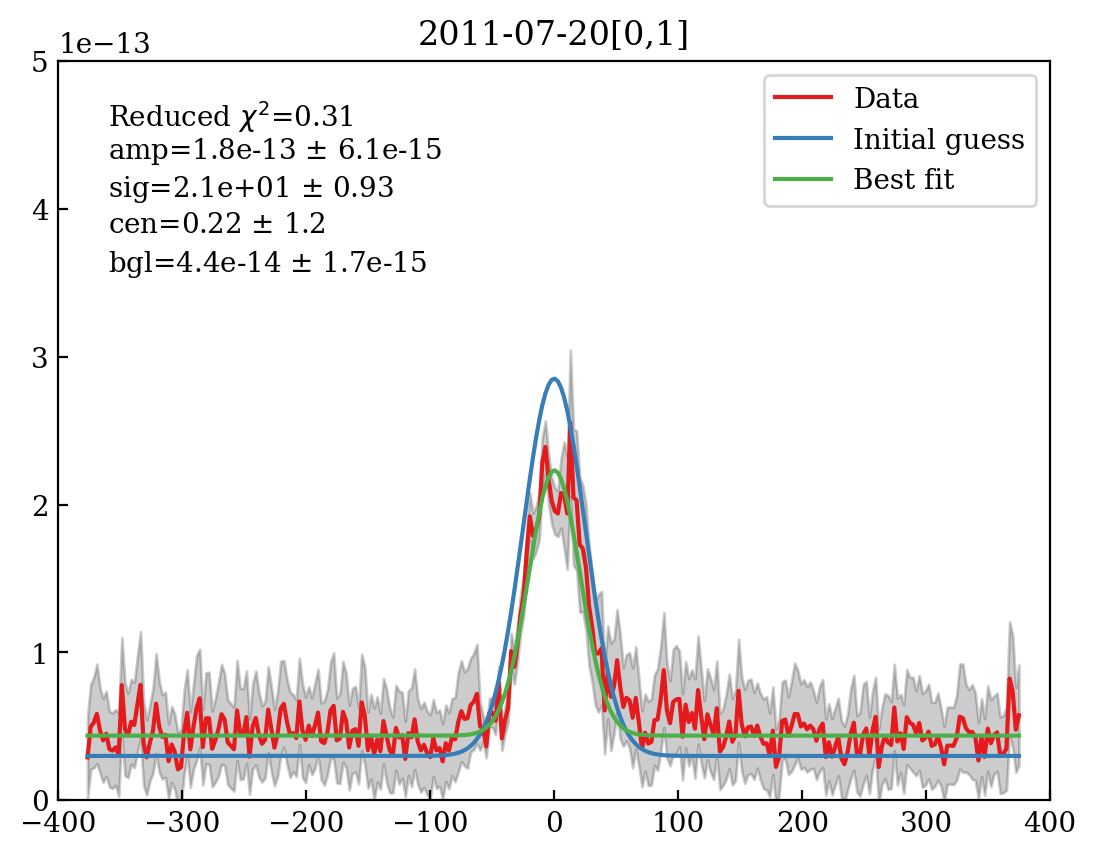

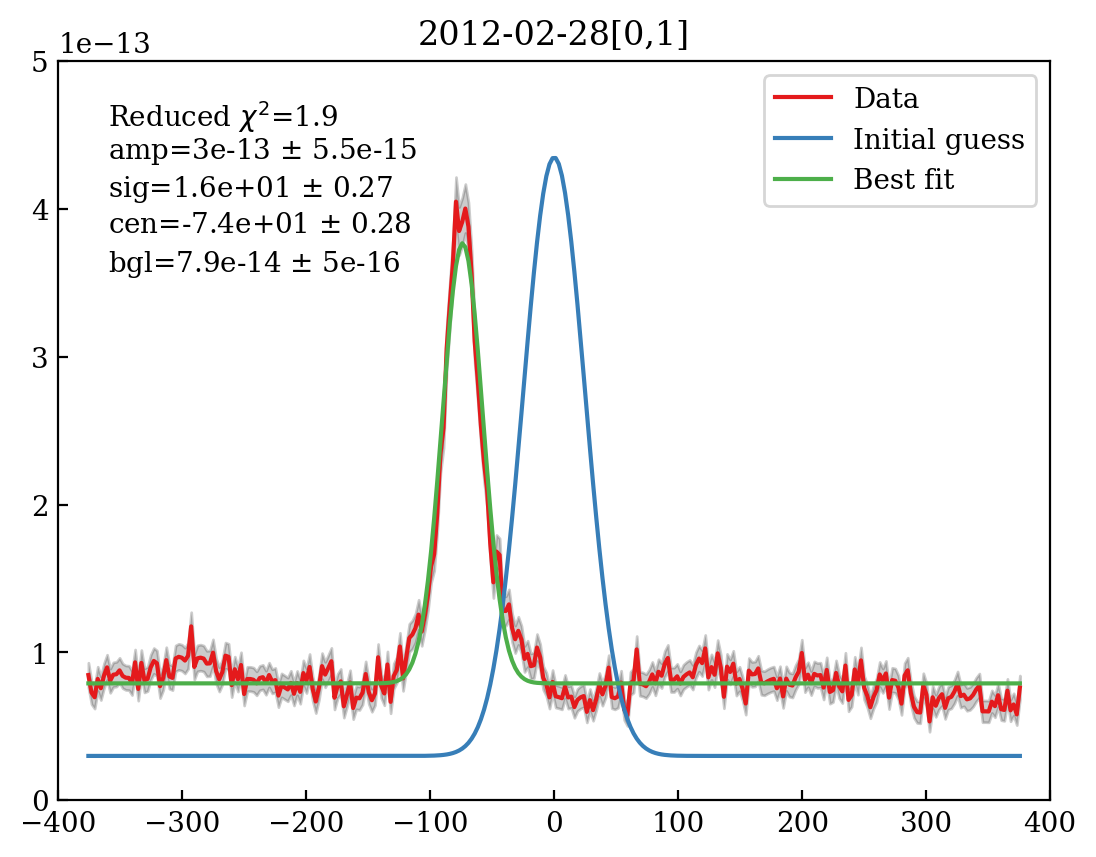

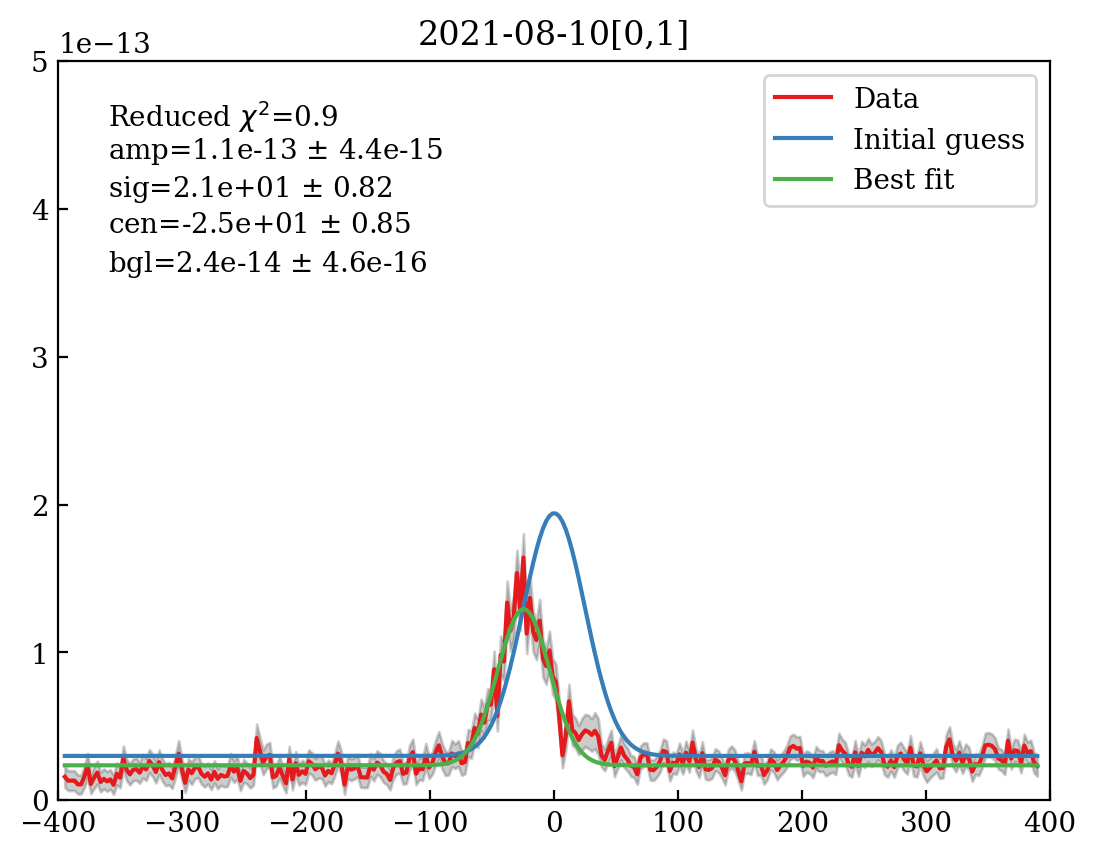

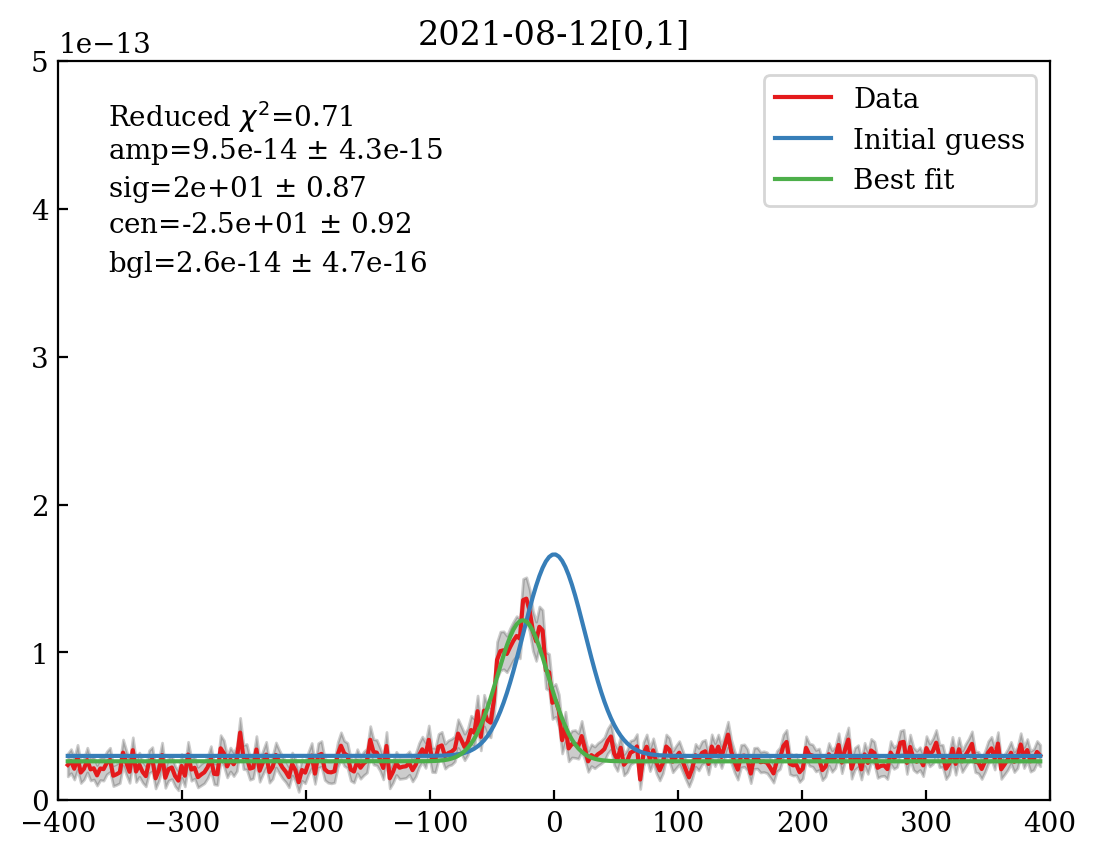

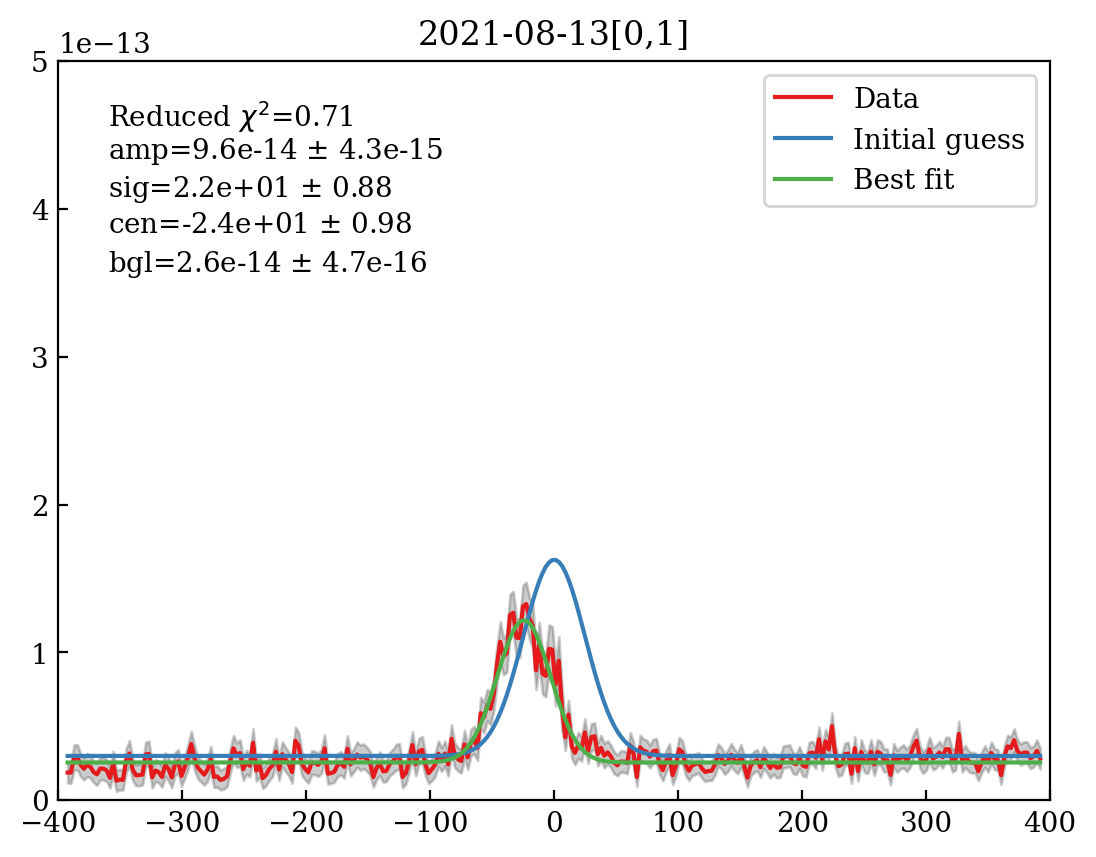

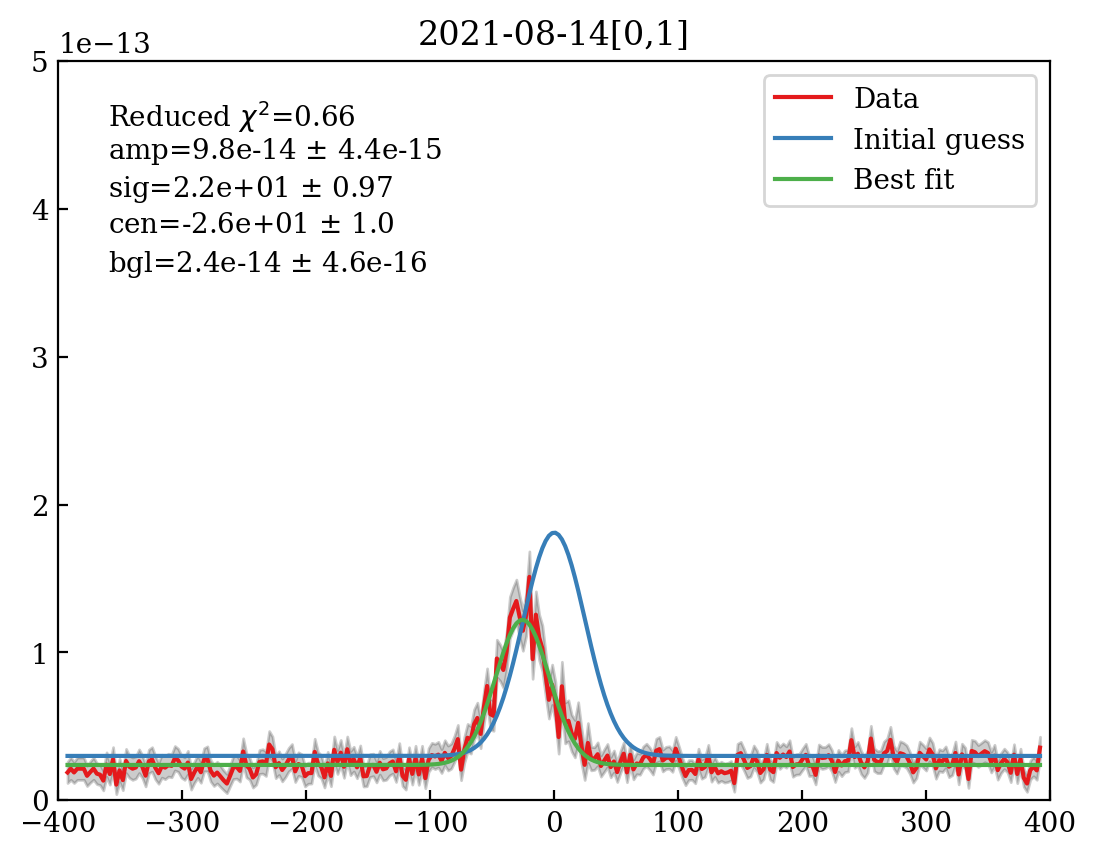

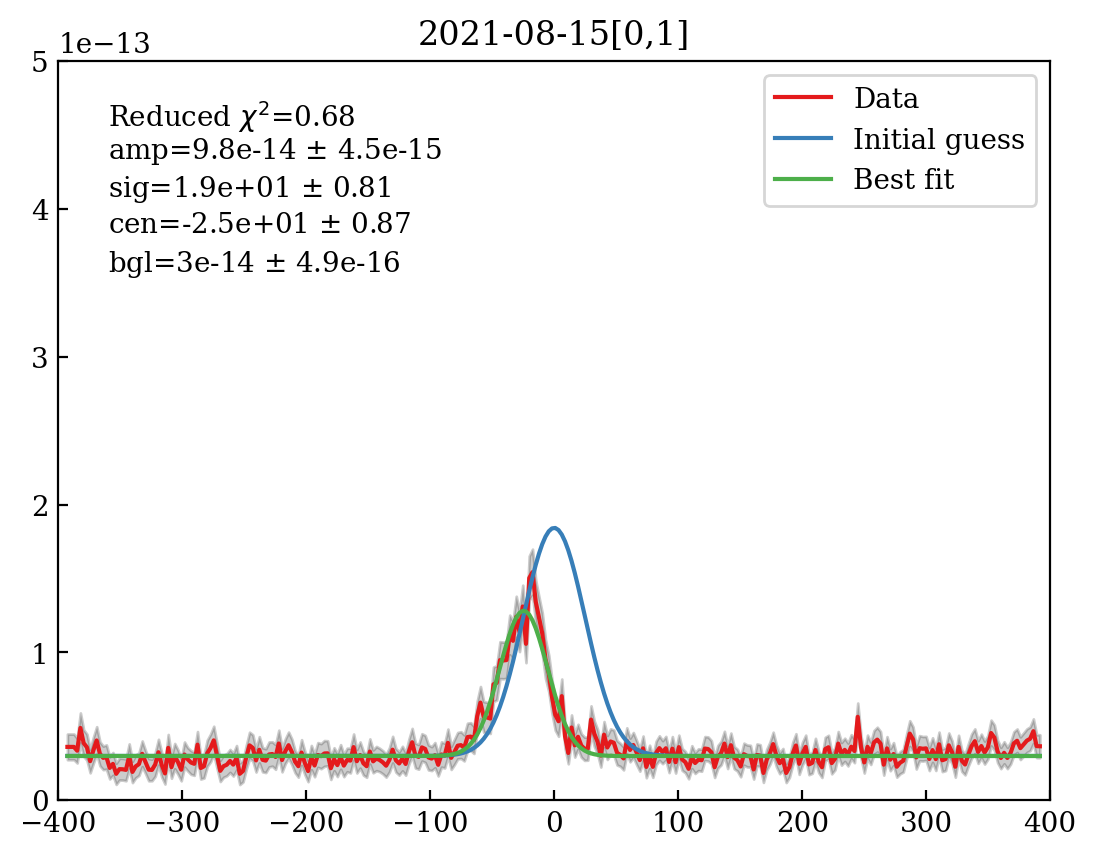

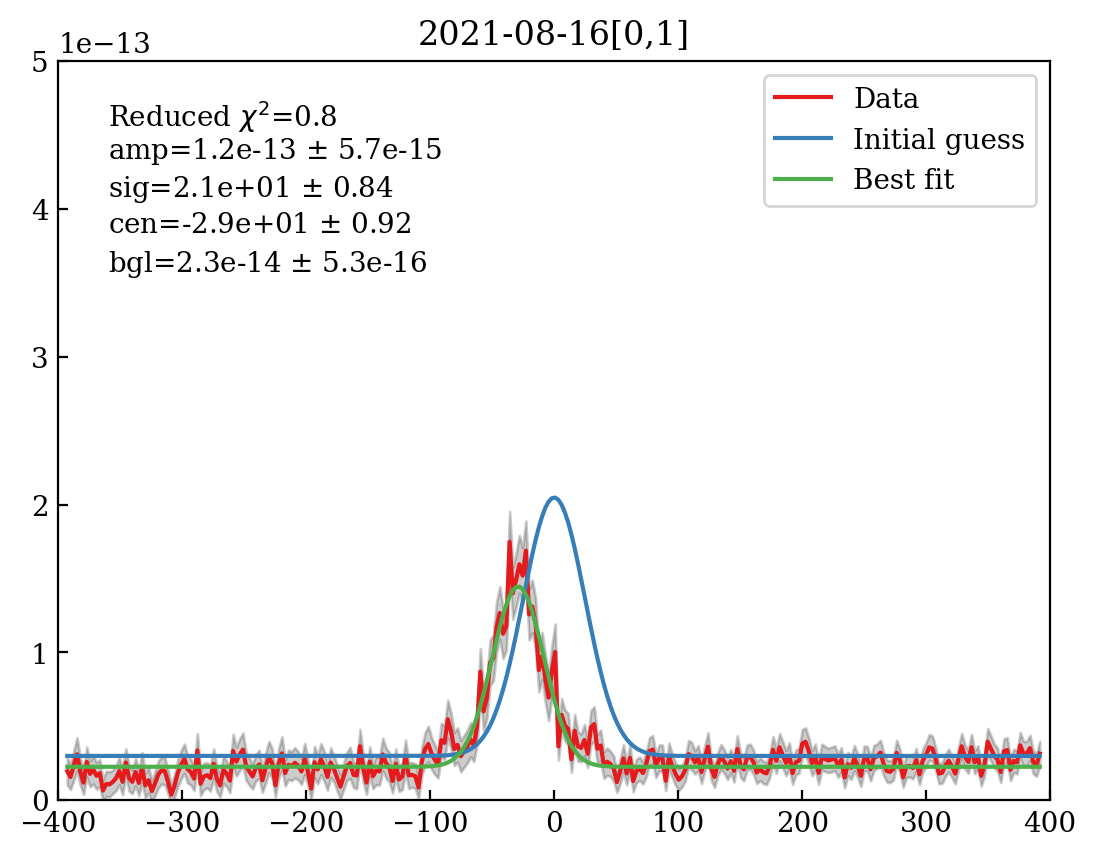

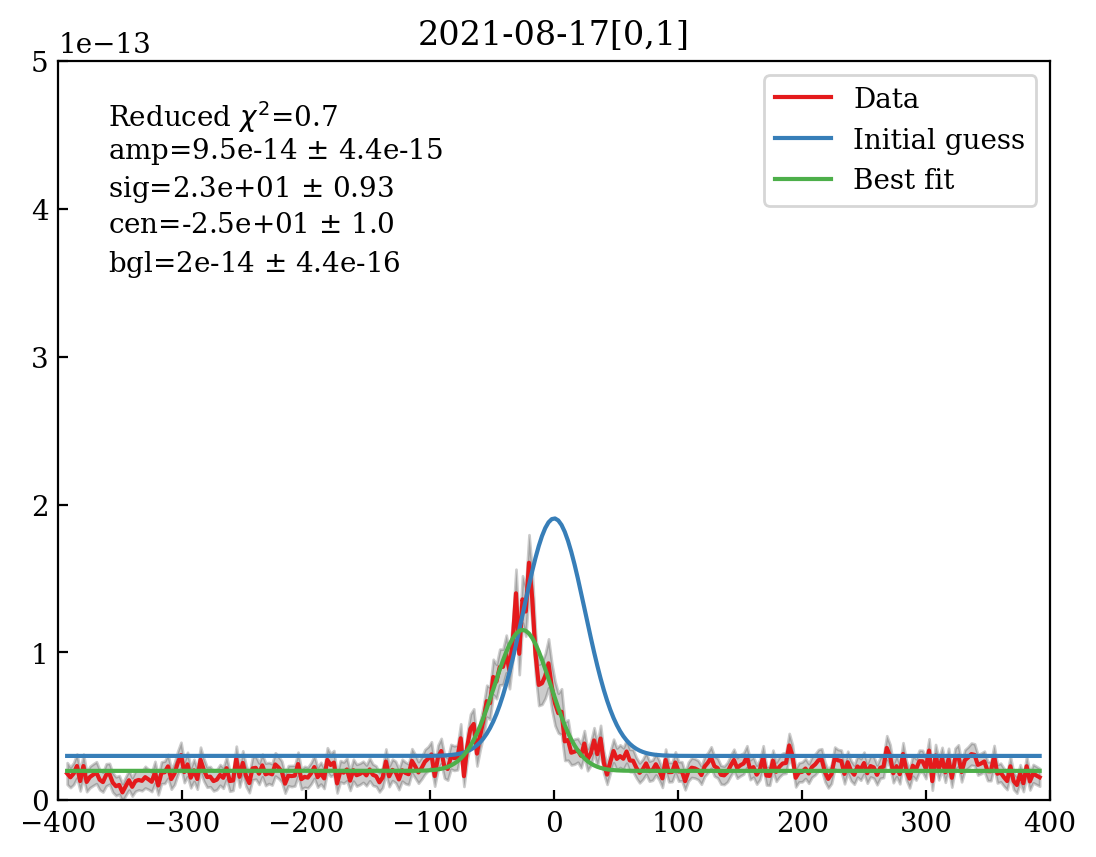

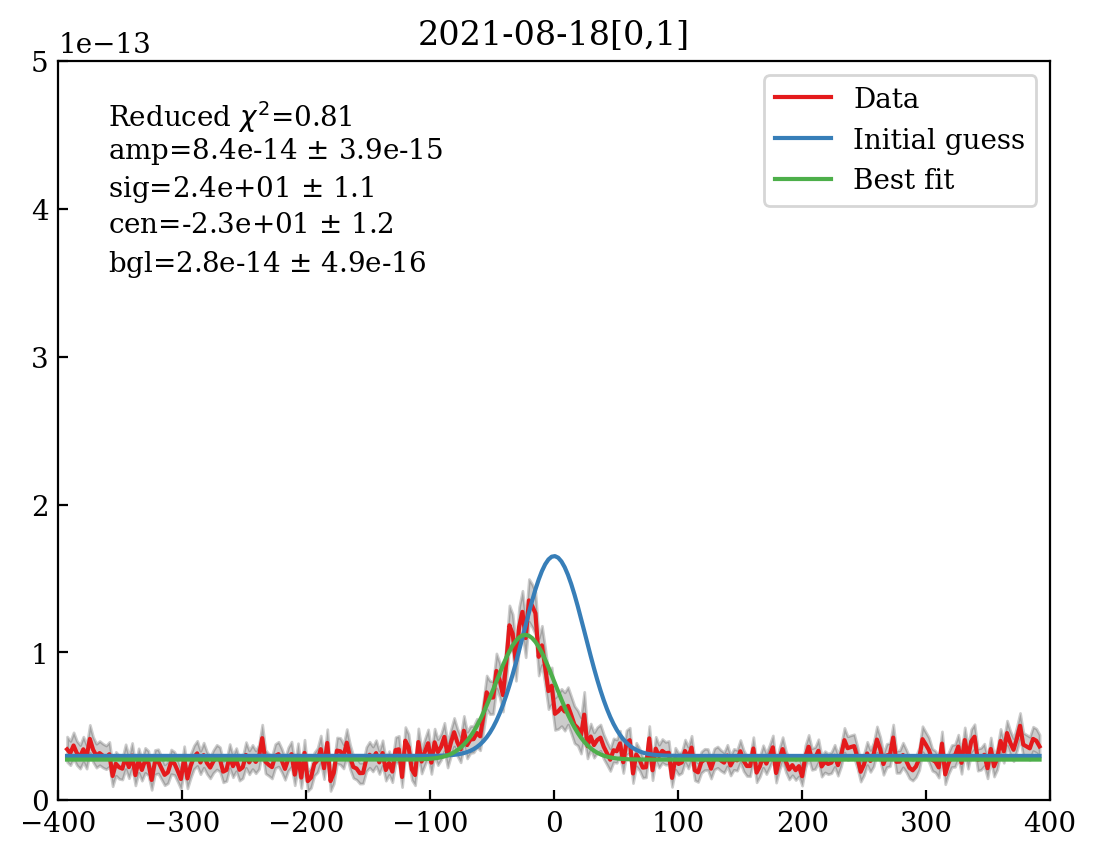

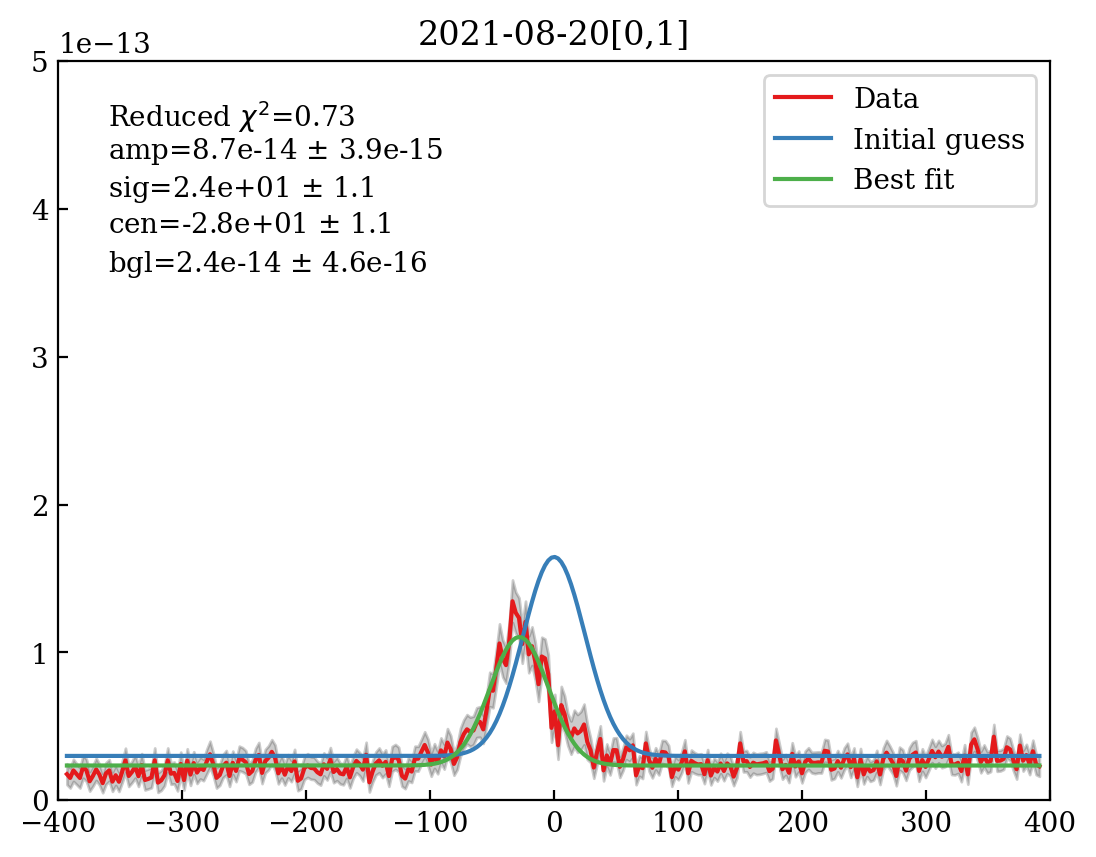

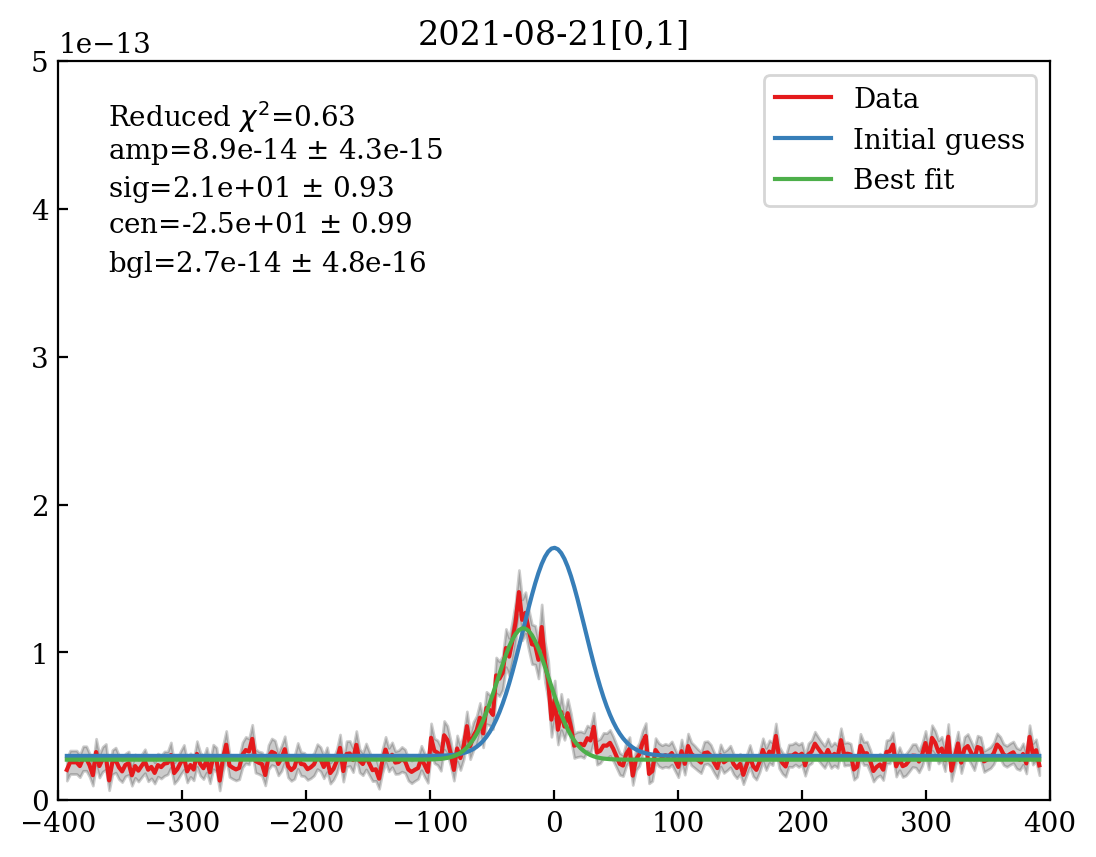

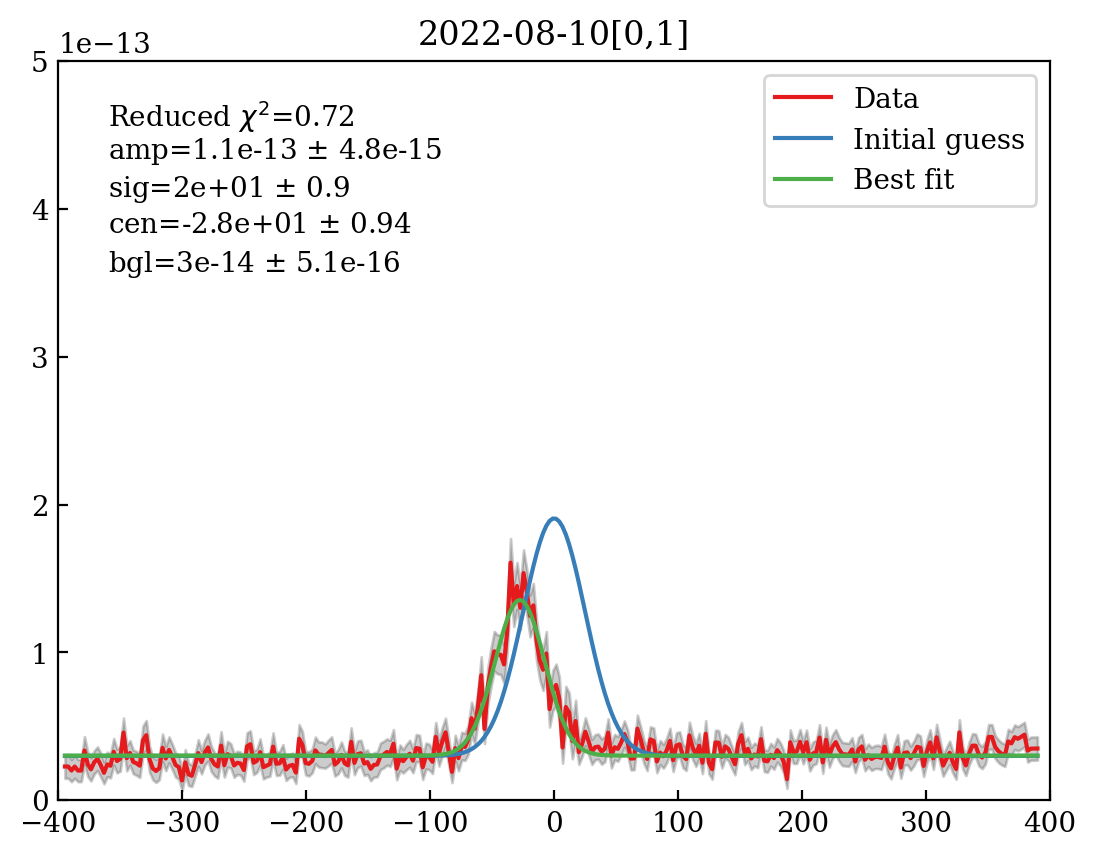

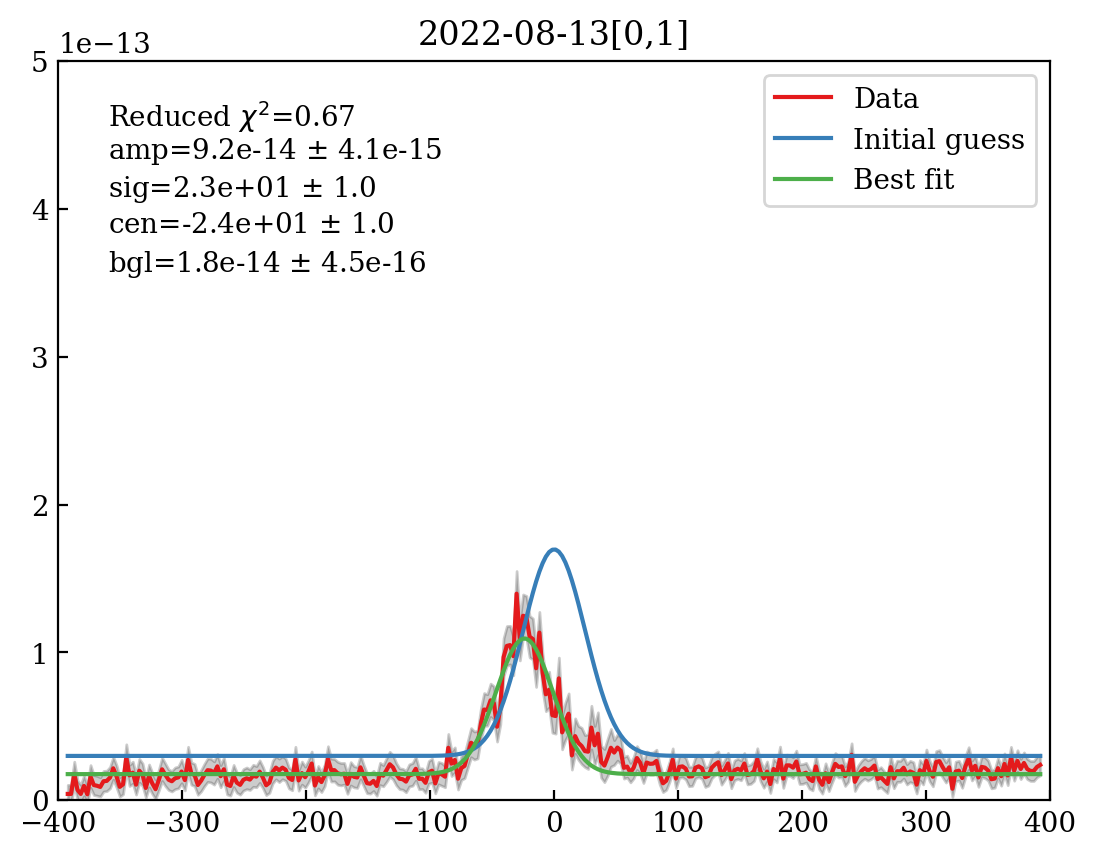

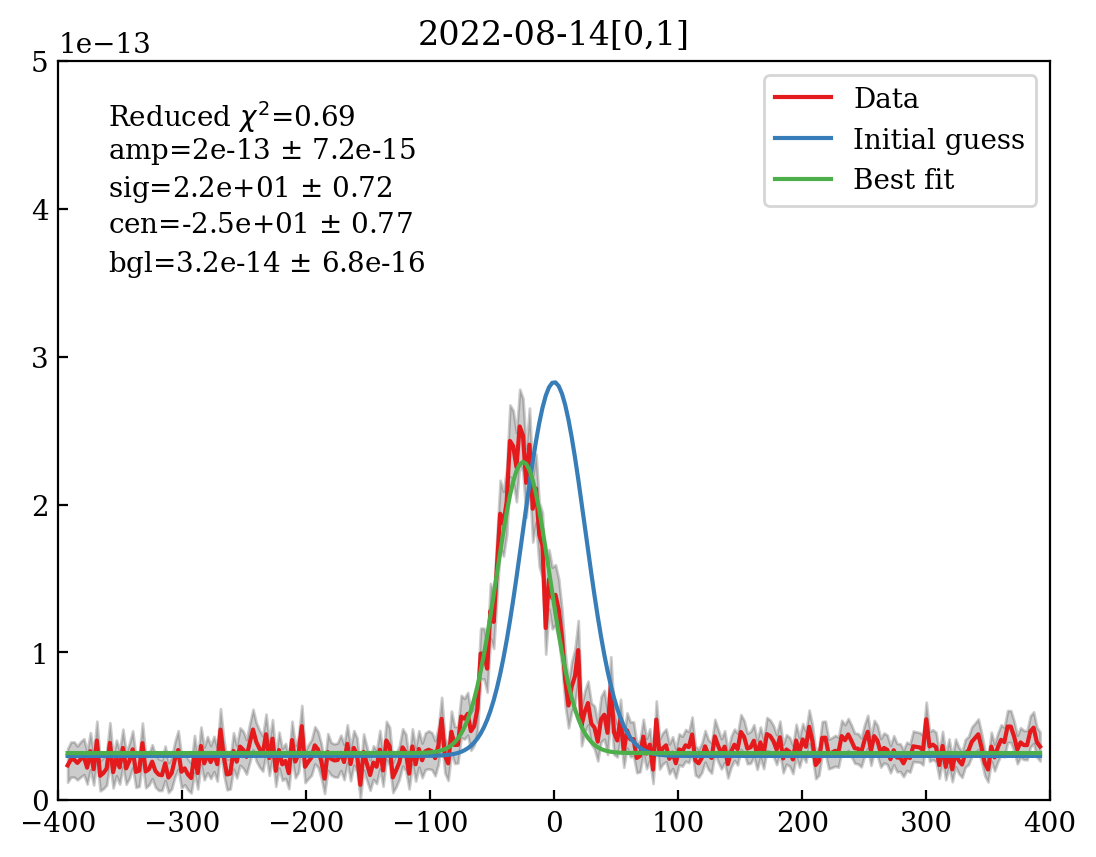

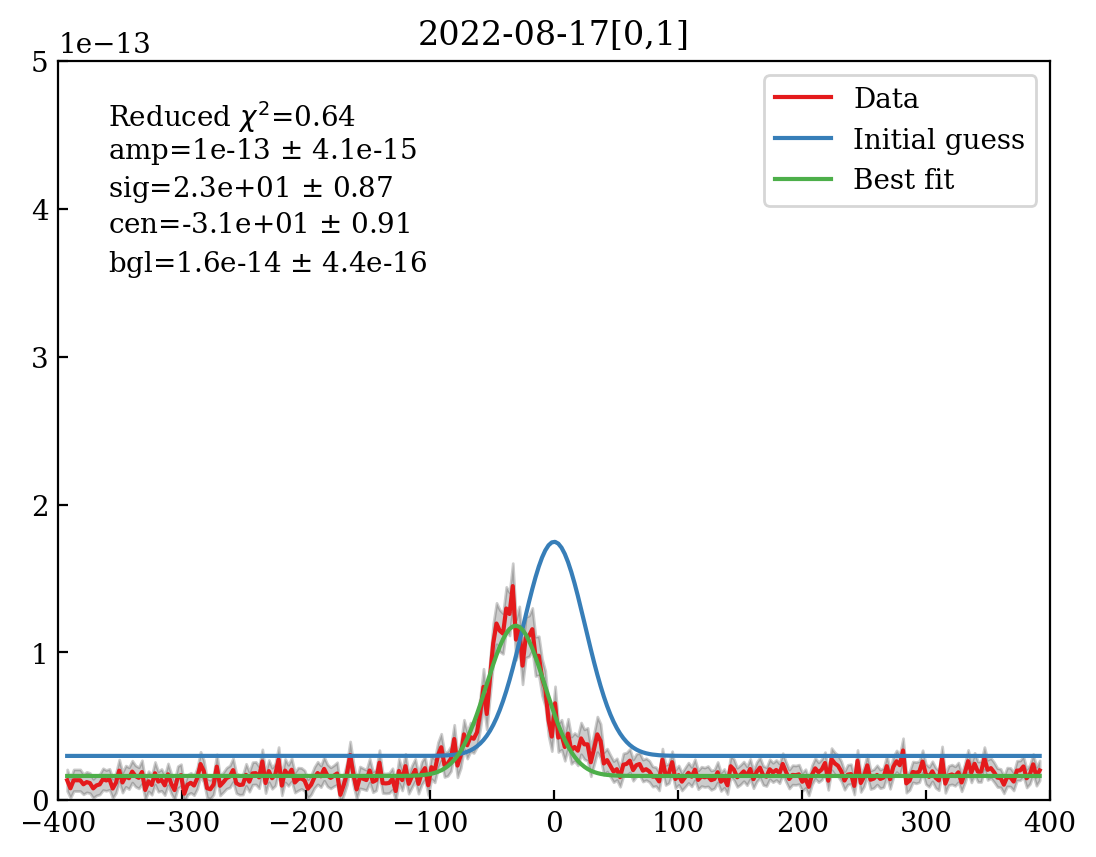

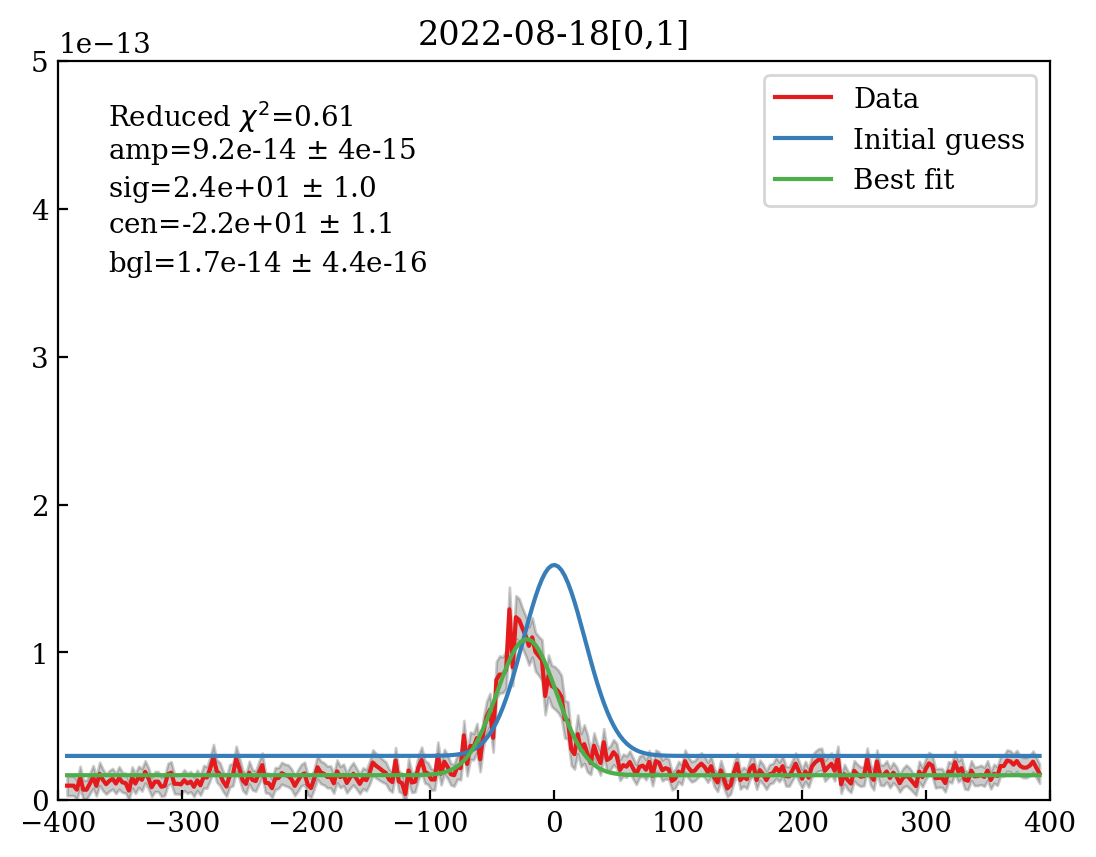

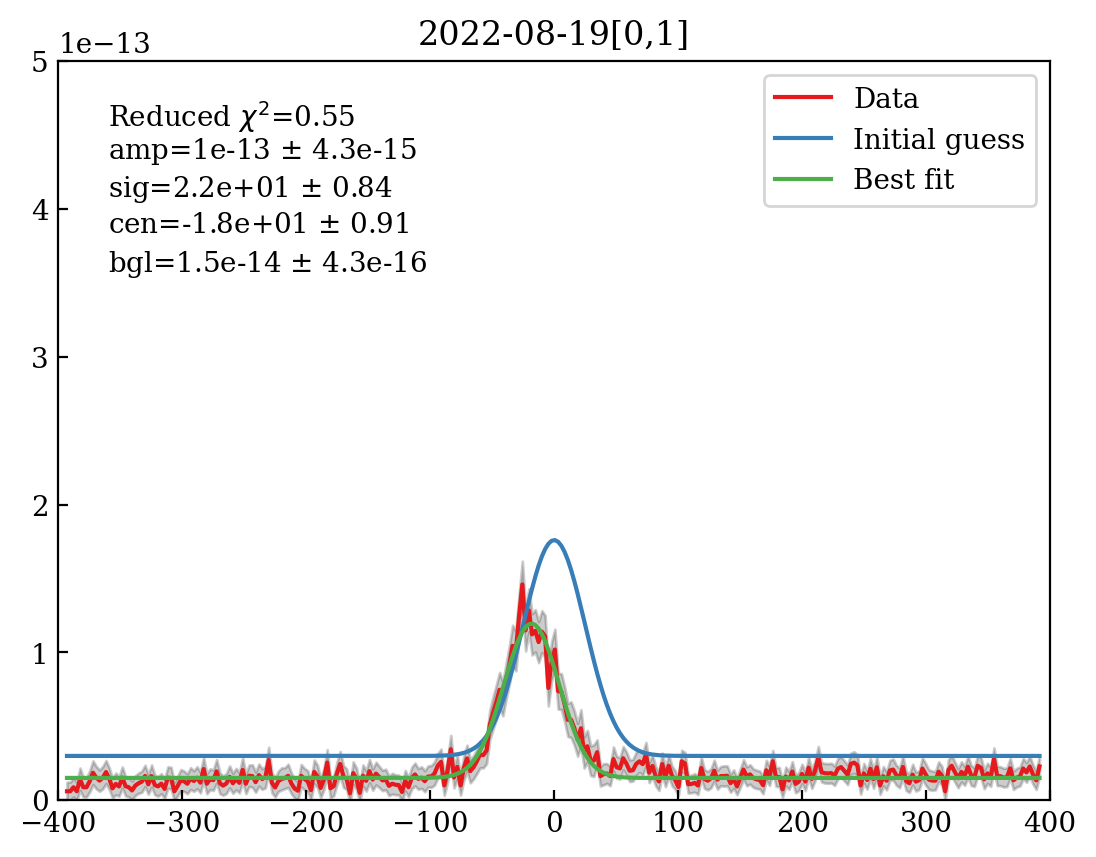

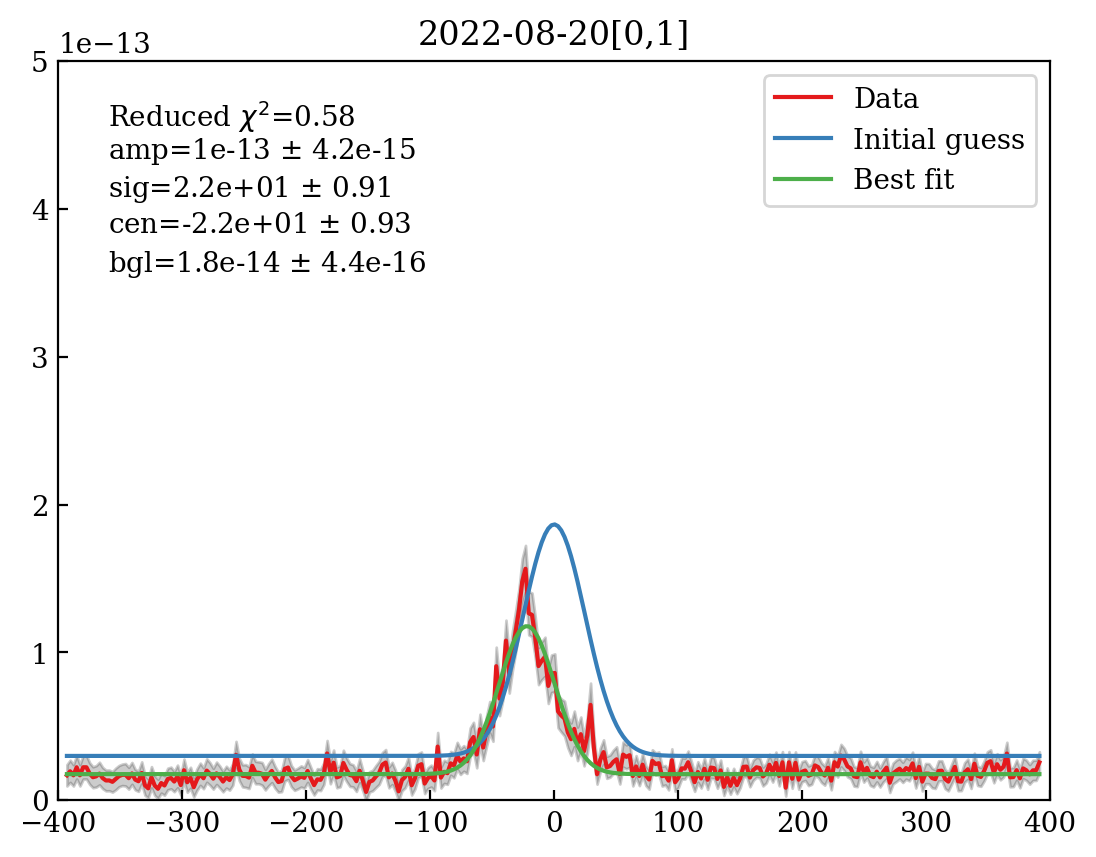

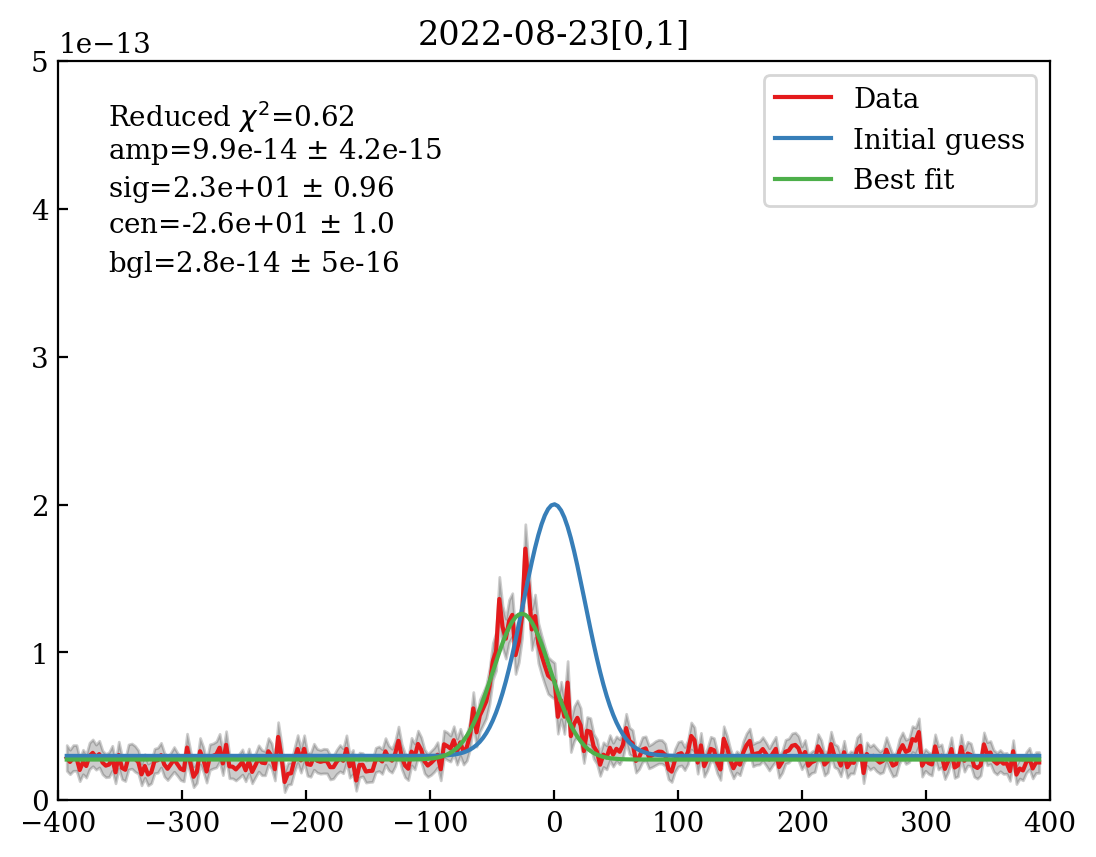

In [65]:
lineModel = Model(gaussian)
for transition_plot in prog_df['transition'].unique():
    mask = prog_df['transition']==transition_plot

    for _, row_prog in prog_df[mask].iterrows():
        
        lineParam = lineModel.make_params(amp=max(row_prog['flux'].value),
                                        sig=25,
                                        cen=0,
                                        bgl=0.3e-13
                                        )

        #set parameter limits
        lineParam['amp'].min = 0
        lineParam['amp'].max = 2*max(row_prog['flux'].value+row_prog['fluxerr'].value)
        #lineParam['amp'].set(0.95*max(exampleLine['flux'].value), vary=False)
        lineParam['sig'].min = 0.0
        lineParam['sig'].max = 3 * lineParam['sig'].value
        lineParam['cen'].min = -100 #u.km/u.s
        lineParam['cen'].max = 50 #u.km/u.s
        lineParam['bgl'].min = 1e-15
        lineParam['bgl'].max = 2e-13

        lineFit = lineModel.fit(row_prog['flux'].value, 
                                lineParam, 
                                x=row_prog['velocity'].value, 
                                weights=1/row_prog['fluxerr'].value, 
                                scale_covar=False
                                )

        initFit = lineFit.init_fit
        bestFit = lineFit.best_fit
        bestChi = lineFit.chisqr
        bestRed = lineFit.redchi
        bestPar = lineFit.params
        x = row_prog['velocity']
        fig, ax = plt.subplots(dpi=200)
        ax.plot(x, row_prog['flux'], label='Data')
        ax.plot(x, initFit, label='Initial guess')
        ax.plot(x, bestFit, label='Best fit')
        ax.set_title(row_prog['obsdate']+ transition_plot)
        ax.fill_between(x.value, row_prog['flux'].value-row_prog['fluxerr'].value, row_prog['flux'].value+row_prog['fluxerr'].value, color='black', alpha=0.2)
        ax.text(0.05,0.95, f'Reduced ${{\chi^2}}$={bestRed:0.2}', transform=ax.transAxes, verticalalignment='top')
        for i, param in enumerate(bestPar):
            ax.text(0.05,0.95-(0.051*(i+1)), f'{bestPar[param].name}={bestPar[param].value:0.2} $\pm$ {bestPar[param].stderr:0.2}', transform=ax.transAxes, verticalalignment='top')
        ax.legend()
        ax.set_ylim(0,5e-13)
        ax.set_xlim(-400,400)
        fig.show()

In [67]:
print("max flux+err:", max(row_prog['flux'].value + row_prog['fluxerr'].value))
print("flux values:", row_prog['flux'].value)
print("fluxerr values:", row_prog['fluxerr'].value)


max flux+err: 3.570825763191246e-14
flux values: [7.90589665e-15 7.90575908e-15 7.90673232e-15 7.90539676e-15
 1.01417416e-14 7.15984633e-15 7.77467305e-15 6.18828020e-15
 6.54922883e-15 6.68150010e-15 8.30594325e-15 7.46505681e-15
 6.74020983e-15 7.99796479e-15 6.58217673e-15 6.04611854e-15
 5.57159027e-15 3.55800569e-15 6.07594260e-15 6.53876403e-15
 5.86339060e-15 6.34957533e-15 6.29245606e-15 5.40446020e-15
 7.33360863e-15 5.34775573e-15 4.32218455e-15 4.16083083e-15
 4.33170088e-15 6.84367617e-15 4.31260454e-15 5.77408262e-15
 6.28287949e-15 5.62454575e-15 6.43917864e-15 8.39921121e-15
 4.60150274e-15 5.96705017e-15 6.57463413e-15 5.90049751e-15
 6.86972887e-15 6.30038680e-15 5.77729444e-15 6.99153430e-15
 7.48829702e-15 4.04273787e-15 7.15992766e-15 9.02033687e-15
 4.49027719e-15 4.56693592e-15 6.27844976e-15 5.73601954e-15
 8.30174253e-15 4.09954690e-15 4.23209157e-15 6.20249950e-15
 9.36813842e-15 8.46167087e-15 8.78120863e-15 7.58938890e-15
 9.16450192e-15 7.96236635e-15 9.043